In [1]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures

#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Raw Data

In [2]:
#Set dataset

datasetDirectory = ""

In [3]:
#Import raw JIRA dataset
rawData_JIRA_dealService = pd.read_csv('../data/01_raw/deal-service.csv')

#import
rawData_SVN_dealService = loadCommits('../data/01_raw/dealservice-dump.txt')

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [4]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+|AFI+.[0-9]+|EM+.[0-9]+|OE+.[0-9]+|EM+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noInterpunction)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(tokensWithoutSW)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [5]:
#Start timer
startTime = time.time() 

intermediateData_SVN_dealService = cleanCommitData(rawData_SVN_dealService)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_dealService.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_dealService.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_dealService.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_dealService.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 9.17812204360962 seconds


In [6]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


In [7]:
#Rename key to Issue key
#rawData_JIRA_academyMay = rawData_JIRA_academyMay.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_dealService = cleanJiraData(dataFrame = rawData_JIRA_dealService, cleanComments = True, commentAmount = 35)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_dealService.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_dealService.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_dealService.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_dealService.pkl")

1/4) Finished Cleaning Summaries after 0.18485212326049805 sec
2/4) Finished Cleaning Description after 0.7865664958953857 sec
3/4) Finished Cleaning Dates after 0.8022205829620361 sec
4/4) Finished Cleaning Comments after 2.0272841453552246 sec


## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA UNIGRAM

In [8]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [9]:
#Create JIRA corpus for dealService dataset
intermediateData_JIRA_dealServiceCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Summary)
intermediateData_JIRA_dealServiceCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Description)
intermediateData_JIRA_dealServiceCorpusComments = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Comments)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dealServiceCorpus = [i+" "+j+" "+k for i,j,k in zip(intermediateData_JIRA_dealServiceCorpusSummary,
                                                                             intermediateData_JIRA_dealServiceCorpusDescription,
                                                                             intermediateData_JIRA_dealServiceCorpusComments
                                                                            )]

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dealServiceCorpus, f)

Bigram corpora

In [10]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [11]:
#Create JIRA corpus for dealService dataset
intermediateData_JIRA_dealServiceCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Summary_2grams)
intermediateData_JIRA_dealServiceCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Description_2grams)
intermediateData_JIRA_dealServiceCorpusComments_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Comments_2grams)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dealServiceCorpus_2gram = [i+" "+j+" "+k  for i,j,k in zip(intermediateData_JIRA_dealServiceCorpusSummary_2grams,
                                                                             intermediateData_JIRA_dealServiceCorpusDescription_2grams,
                                                                             intermediateData_JIRA_dealServiceCorpusComments_2grams
                                                                                  )]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dealServiceCorpus_2gram, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [12]:
intermediateData_SVN_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dealService.pkl")

In [13]:
#Create corpus for log messages
intermediateData_SVNLogs_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs)

#Create corpus for unit names
intermediateData_SVNUnitNames_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs + intermediateData_SVN_dealService.Unit_names)
intermediateData_SVN_dealServiceCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs + intermediateData_SVN_dealService.Unit_names)
#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVNLogs_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dealServiceCorpus, f)

with open('../data/02_intermediate/intermediateData_SVNUnitNames_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dealServiceCorpus, f)

with open('../data/02_intermediate/intermediateData_SVN_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dealServiceCorpus, f)
    
with open('../data/02_intermediate/intermediateData_SVN_dealServiceCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dealServiceCorpusAll, f)

bigram corpora

In [14]:
intermediateData_SVNLogs_dealServiceCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dealService.Logs_2grams)
intermediateData_SVNUnitNames_dealServiceCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dealService.Unit_names_2grams)
with open('../data/02_intermediate/intermediateData_SVNLogs_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dealServiceCorpus_2gram, f)
    
    
with open('../data/02_intermediate/intermediateData_SVNUnitNames_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dealServiceCorpus_2gram, f)

# 3. Preprocess Data

In [15]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_dealService.pkl")

intermediateData_SVN_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dealService.pkl")

intermediateData_JIRA_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl')
intermediateData_JIRA_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl')
#intermediateData_SVN_dealServiceCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpusAll.pkl')
#intermediateData_SVN_dealServiceCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpusModel.pkl')
intermediateData_SVN_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [16]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

#Create cartesian products JIRA x Commits
processedData_dealServiceCartesian = intermediateData_JIRA_dealService.merge(intermediateData_SVN_dealService, how='cross')
processedData_dealServiceCartesian.info()
processedData_dealServiceCartesian = processedData_dealServiceCartesian.drop(processedData_dealServiceCartesian[processedData_dealServiceCartesian.Jira_created_date > processedData_dealServiceCartesian.Commit_date].index)

#Create a pickle file for all intermediate datasets
processedData_dealServiceCartesian.to_pickle(path= "../data/03_processed/processedData_dealServiceCartesian.pkl")



<class 'pandas.core.frame.DataFrame'>
Int64Index: 258635 entries, 0 to 258634
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Issue_key_jira              258635 non-null  object        
 1   Assignee                    213785 non-null  object        
 2   Jira_created_date           258635 non-null  datetime64[ns]
 3   Jira_updated_date           258635 non-null  datetime64[ns]
 4   Jira_resolved_date          218270 non-null  datetime64[ns]
 5   Summary                     258635 non-null  object        
 6   Summary_2grams              258635 non-null  object        
 7   Summary_3grams              258635 non-null  object        
 8   Description                 258635 non-null  object        
 9   Description_2grams          258635 non-null  object        
 10  Description_3grams          258635 non-null  object        
 11  Comments                    258635 non-

AttributeError: 'numpy.ndarray' object has no attribute 'is_valid'

## 3.1 Preprocess Data - Create Labels

In [17]:
#Create new dataFrames for the time features
processedData_dealServiceLabels = pd.DataFrame() 


#Create a column, which indicates which traces are valid.
processedData_dealServiceLabels["is_valid"] = processedData_dealServiceCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for dealService")

#Save intermediate results
processedData_dealServiceLabels.to_pickle(path= "../data/03_processed/processedData_dealServiceLabels.pkl")

processedData_dealServiceLabels.info()

Finished creating labels for dealService
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89233 entries, 1487 to 258634
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_valid  89233 non-null  bool 
dtypes: bool(1)
memory usage: 784.3 KB


In [18]:
#processedData_dealServiceLabels[processedData_dealServiceLabels.is_valid == True].count()
processedData_dealServiceLabels[processedData_dealServiceLabels.is_valid == True].count()

is_valid    420
dtype: int64

## 3.2 Preprocess Data - Create Time-Related Features

In [19]:
#Create new dataFrames for the time features
processedData_dealServiceFeaturesTime = pd.DataFrame() 


#Calculate the time features for data Processing Dataset
processedData_dealServiceFeaturesTime['Creation_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_dealServiceFeaturesTime['Updated_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_dealServiceFeaturesTime['Resolved_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")

#Create a pickle file for all intermediate datasets
processedData_dealServiceFeaturesTime.to_pickle(path= "../data/03_processed/processedData_dealServiceFeaturesTime.pkl")

Finished data Processing


## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [20]:
#Create new dataFrames for the Stakeholder features
processedData_dealServiceFeaturesStakeholder = pd.DataFrame() 

processedData_dealServiceFeaturesStakeholder['Assignee_is_commiter'] = processedData_dealServiceCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished dealService")

#Create a pickle file for all intermediate datasets
processedData_dealServiceFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl")


Finished dealService


In [21]:
processedData_dealServiceFeaturesStakeholder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89233 entries, 1487 to 258634
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Assignee_is_commiter  76693 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


## 3.4 Preprocess Data - Create Cosine Similarity Features
### 3.4.1 dealService - Cosine Similarity UniGrams

In [22]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)

def calculateCosineSimilarityNGrams(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

In [23]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       dealService              #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVN_dealServiceCountVectorizer = CountVectorizer()
processedData_SVN_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealServiceCorpus)

processedData_SVNLogs_dealServiceCountVectorizer = CountVectorizer()
processedData_SVNLogs_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVNLogs_dealServiceCountVectorizer, intermediateData_SVNLogs_dealServiceCorpus)

processedData_SVNUnitNames_dealServiceCountVectorizer = CountVectorizer()
processedData_SVNUnitNames_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVNUnitNames_dealServiceCountVectorizer, intermediateData_SVNUnitNames_dealServiceCorpus)

#instantiate CountVectorizer() for JIRA - unigram
processedData_JIRA_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRA_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpus)

processedData_JIRASummaries_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRASummaries_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRASummaries_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusSummary)

processedData_JIRADescriptions_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRADescriptions_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRADescriptions_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusDescription)

processedData_JIRAComments_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRAComments_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRAComments_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusComments)


################# Bigrams ###############
#instantiate CountVectorizer() for SVN - bigrams
processedData_SVNLogs_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_SVNLogs_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNLogs_dealServiceCountVectorizer_2gram, intermediateData_SVNLogs_dealServiceCorpus_2gram)

processedData_SVNUnitNames_dealServiceCountVectorizer_2gram = CountVectorizer()
processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, intermediateData_SVNUnitNames_dealServiceCorpus_2gram)


#instantiate CountVectorizer() for JIRA - biigram
processedData_JIRA_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpus_2gram)

processedData_JIRASummaries_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRASummaries_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRASummaries_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusSummary_2grams)

processedData_JIRADescriptions_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRADescriptions_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRADescriptions_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusDescription_2grams)

processedData_JIRAComments_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRAComments_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRAComments_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusComments_2grams)




#### 3.4.1 [VSM unigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [24]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsJiraAsQuery["vsm_logs_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM Logs Jira as query' after 5 minutes and 7.45426869392395 seconds


#### 3.4.2 [VSM unigram] Similarity between JIRA issue and Commit Log - Log As Query

In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsLogAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsLogAsQuery["vsm_logs_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsLogAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 47.17534613609314 seconds


#### 3.4.3 [VSM unigram] Similarity between JIRA issue and Unit Names - JIRA As Query

In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesJiraAsQuery["vsm_unit_names_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 25.189353227615356 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Jira As Query

In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery["vsm_summary_logs_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 47.32737469673157 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Log As Query

In [28]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsLogsAsQuery["vsm_summary_logs_logs_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 39.080777645111084 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - Summary As Query

In [29]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery["vsm_summary_unitNames_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 0.03845024108886719 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - UnitNames As Query

In [30]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery["vsm_summary_unitNames_unitNames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 20.528594732284546 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names - JIRA As Query

In [31]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery["vsm_verb_pruning_unit_names_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query and verb pruning' after " + timeDifference)

Finished creating 'VSM Logs Jira as query and verb pruning' after 5 minutes and 17.80805230140686 seconds


#### 3.4.4 [VSM unigram] Similarity between JIRA issue and Unit Names  - Unit Names As Query

In [32]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery["vsm_unit_names_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 14.296204328536987 seconds


#### 3.4.5 [VSM unigram] Similarity between JIRA description and commit log - Description as query

In [33]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionDescriptionAsQuery["vsm_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 23.25654435157776 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as descrintion

In [34]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionLogsAsQuery["vsm_description_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 8.73307490348816 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

In [35]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery["vsm_comments_unitnames_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 36.285478353500366 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

In [36]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery["vsm_comments_unitnames_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 1.3787086009979248 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and commit log - Comment as description

In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsCommentsAsQuery["vsm_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 28.286805868148804 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as description

In [38]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsLogsAsQuery["vsm_comments_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 18.10190200805664 seconds


#### [VSM bigram] Similarity between JIRA comments and Commit Logs - Logs as query

In [39]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram["vsm_comments_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 48.930150508880615 seconds


#### 3.4.5 [VSM bigram] Silarity between JIRA Comment and commit log - Comment as query

In [40]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram["vsm_comments_comments_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRAComments_dealServiceCountVectorizer_2gram, processedData_JIRAComments_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 20.082991123199463 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Unit Names as query

In [41]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery["vsm_unitnames_description_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 44.73593521118164 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Description as query

In [42]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery["vsm_unitnames_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 4.07165265083313 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Unit Names as query

In [43]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery["vsm_unitnames_comments_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 46.19073271751404 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Comments as query

In [44]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery["vsm_unitnames_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 21.161534309387207 seconds


In [45]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely)- JIRA as query

In [46]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnJiraJiraAsQuery["vsm_svn_jira_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnJiraJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 51.4496693611145 seconds


In [47]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely) - SVN as query

In [48]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnJiraSvnAsQuery["vsm_svn_jira_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnJiraSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 53 minutes and 56.870359897613525 seconds


In [49]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - SVN as query

In [50]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnSummarySvnAsQuery["vsm_svn_summary_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnSummarySvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 42.126174211502075 seconds


In [51]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - Summary as query

In [52]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnSummarySummaryAsQuery["vsm_svn_summary_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnSummarySummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 14.52494502067566 seconds


In [53]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - SVN as query

In [54]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery["vsm_svn_description_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 3.8073415756225586 seconds


In [55]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - Description as query

In [56]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery["vsm_svn_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 48.51523017883301 seconds


In [57]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - SVN as query

In [58]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnCommentsSvnAsQuery["vsm_svn_comments_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Comments, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnCommentsSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 44.62076997756958 seconds


In [59]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - Comments as query

In [60]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery["vsm_svn_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Comments, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 36.02896761894226 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names and verb pruning - Unit Names As Query

In [61]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery["vsm_verb_pruning_unit_names_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 2.5970616340637207 seconds


#### 3.4.5 [VSM bigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [62]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsJiraAsQuery_2gram["vsm_logs_jira_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dealServiceCountVectorizer_2gram, processedData_JIRA_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 30.555123805999756 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Commit Log - Logs As Query

In [63]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsLogAsQuery_2gram["vsm_logs_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer_2gram, processedData_SVNLogs_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsLogAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 28.31280779838562 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - Jira As Query

In [64]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram["vsm_unit_names_jira_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer_2gram, processedData_JIRA_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 31.310052394866943 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - UnitNames As Query

In [65]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram["vsm_unit_names_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 58.085158586502075 seconds


#### [VSM bigram] Similarity between Logs and Description - Logs as Query

In [66]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram["vsm_description_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 59.97384858131409 seconds


#### [VSM bigram] Similarity between Logs and Description - Description as Query

In [67]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram["vsm_description_description_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_dealServiceCountVectorizer_2gram, processedData_JIRADescriptions_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Bigrams' after " + timeDifference)

Finished creating 'VSM Bigrams' after 5 minutes and 13.67255425453186 seconds


#### [VSM bigram] Similarity between Logs and Summary - Logs as Query

#### [VSM bigram] Similarity between Logs and Summary - Summary as Query

In [68]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram["vsm_summary_logs_summary_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityNGrams(x.Summary, x.Logs, processedData_JIRASummaries_dealServiceCountVectorizer_2gram, processedData_JIRASummaries_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 54.002402544021606 seconds


## 3.6 Document Statistics

### dealService

In [69]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_dealServiceFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_dealServiceFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_dealServiceFeaturesTotalWordCount["total_term_count_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_dealServiceFeaturesTotalWordCount["total_term_count_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_dealServiceFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")

processedData_JIRA_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

Finished creating document statistics in 0 minutes and 17.35699486732483 seconds


## 3.7 Query Quality

In [70]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

In [71]:
#Read datasets from disk
processedData_dealServiceCartesian = pd.read_pickle(r"../data/03_processed/processedData_dealServiceCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_dealServiceCountVectorizer = CountVectorizer()
processedData_SVN_dealServiceTF_IDF = createFittedTF_IDF(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealServiceCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRA_dealServiceTF_IDF = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpus)

#Determine document counts
intermediateData_JIRA_dealService_documentCount = len(intermediateData_JIRA_dealService.index)
intermediateData_SVN_dealService_documentCount = len(intermediateData_SVN_dealService.index)



#### IDF Scores (SVN as Query)

In [72]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                processedData_SVN_dealServiceTF_IDF),axis=1)

processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 28 minutes and 32.79408144950867 seconds


#### IDF Scores (SVNLogs as Query)

In [73]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                processedData_SVNLogs_dealServiceCountTF_IDF),axis=1)

processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_avgIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_maxIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_devIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnLogsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 38.72721982002258 seconds


#### IDF Scores (SVNUnitNames as Query

In [74]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                processedData_SVNLogs_dealServiceCountTF_IDF),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_avgIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_maxIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_devIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 39.77573561668396 seconds


##### IDF Scores (JIRA as Query)

In [75]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRA_dealServiceTF_IDF),axis=1)

processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 92 minutes and 48.95662188529968 seconds


##### IDF Scores (JIRA Summaries as Query)

In [76]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRASummaries_dealServiceCountTF_IDF),axis=1)

processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_avgIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_maxIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_devIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraSummariesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 3 minutes and 45.127768993377686 seconds


##### IDF Scores (JIRA Descriptions as Query)

In [77]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountTF_IDF),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_avgIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_maxIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_devIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 17 minutes and 4.594225168228149 seconds


##### IDF Scores (JIRA Comments as Query)

In [78]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Comments, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountTF_IDF),axis=1)

processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_avgIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraCommentsAsQuery_IDF), axis=1)
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_maxIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraCommentsAsQuery_IDF), axis=1)
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_devIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraCommentsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 33 minutes and 25.290278434753418 seconds


#### ICTF Scores (SVN as query)

In [79]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_avgICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_maxICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnAsQuery_ICTF), axis=1)
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_devICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesICTF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 20 minutes and 4.4400341510772705 seconds


#### ICTF Scores (SVNLogs as query)

In [80]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)
##
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_avgICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnLogsAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_maxICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnLogsAsQuery_ICTF), axis=1)
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_devICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnLogsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 14.88181471824646 seconds


#### ICTF Scores (SVNUnitNames as query)

In [81]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)
##
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnUnitNamesAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_devICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 19.744380474090576 seconds


#### ICTF Scores (JIRA as query)

In [82]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 49.15820527076721 seconds


#### ICTF Scores (JIRA Summaries as query)

In [83]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_avgICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraSummariesAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_maxICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraSummariesAsQuery_ICTF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_devICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraSummariesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 16.560428857803345 seconds


#### ICTF Scores (JIRA Descriptions as query)

In [84]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraDescriptionsAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_devICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 22.565612316131592 seconds


#### ICTF Scores (JIRA Comments as query)

In [85]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_avgICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraCommentsAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_maxICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraCommentsAsQuery_ICTF), axis=1)
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_devICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraCommentsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 36.422266483306885 seconds


#### Entropy (SVN as query)

In [86]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Commit_natural_text),axis=1)

processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_avgEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_medEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_maxEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_devEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnAsQuery_Entropy), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesEntropy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 71 minutes and 30.406294345855713 seconds


#### Entropy (SVNLogs as query)

In [87]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Logs),axis=1)
##
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_avgEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_medEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_maxEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_devEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnLogsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 4 minutes and 16.636083364486694 seconds


#### Entropy (SVNUnitNames as query)

In [88]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Unit_names),axis=1)
##
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 47 minutes and 27.526021718978882 seconds


#### Entropy (JIRA as query)

In [89]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Jira_natural_text),axis=1)
##
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 52 minutes and 52.43811345100403 seconds


#### Entropy (JIRA Summaries as query)

In [90]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Summary),axis=1)
##
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_medEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_devEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 58.05627369880676 seconds


#### Entropy (JIRA Descriptions as query)

In [91]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Description),axis=1)
##
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 23.865477085113525 seconds


#### Entropy (JIRA Comments as query)

In [92]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Comments),axis=1)
##
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_medEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_devEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 20 minutes and 25.814197301864624 seconds


##### Query Scope (SVN as query)

In [93]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesQueryScope["SvnAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Commit_natural_text, 
                                                                                                                intermediateData_SVN_dealService.Commit_natural_text),axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 5 minutes and 56.84695649147034 seconds


##### Query Scope (SVNLogs as query)

In [94]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesQueryScope["SvnLogsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Logs, 
                                                                                                                intermediateData_SVN_dealService.Logs),axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.65317344665527 seconds


##### Query Scope (SVNUnitNames as query)

In [95]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesQueryScope["SvnUnitNamesAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Unit_names, 
                                                                                                                intermediateData_SVN_dealService.Unit_names),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 47.93760299682617 seconds


##### Query Scope (JIRA as query)

In [96]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_dealService.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 35.85256242752075 seconds


##### Query Scope (JIRA Summaries as query)

In [97]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesQueryScope["JiraSummariesAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Summary, 
                                                                                                                intermediateData_JIRA_dealService.Summary),axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 17.89712142944336 seconds


##### Query Scope (JIRA Descriptions as query)

In [98]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesQueryScope["JiraDescriptionsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Description, 
                                                                                                                intermediateData_JIRA_dealService.Description),axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 56.1099636554718 seconds


##### Query Scope (JIRA Comments as query)

In [99]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesQueryScope["JiraCommentsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Comments, 
                                                                                                                intermediateData_JIRA_dealService.Comments),axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 21.79303526878357 seconds


#### Kullback-Leiber divergence (SVN as query)

In [100]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesSCS["SvnAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 19.22192692756653 seconds


#### Kullback-Leiber divergence (SVNLogs as query)

In [101]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesSCS["SvnLogsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.938369035720825 seconds


#### Kullback-Leiber divergence (SVNUnitNames as query)

In [102]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesSCS["SvnUnitNamesAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 18.892534971237183 seconds


#### Kullback-Leiber divergence (JIRA as query)

In [103]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesSCS["JiraAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 24.89457607269287 seconds


#### Kullback-Leiber divergence (JIRA Summaries as query)

In [104]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesSCS["JiraSummariesAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.886245012283325 seconds


In [105]:
##### Kullback-Leiber divergence (JIRA Description as query)

In [106]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesSCS["JiraDescriptionsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 6.50683331489563 seconds


In [107]:
##### Kullback-Leiber divergence (JIRA Comments as query)

In [108]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesSCS["JiraCommentsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 13.457808494567871 seconds


#### SCQ (SVN as Query)

In [109]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Commit_natural_text, intermediateData_SVN_dealService.Commit_natural_text,
                                                                                                                                         processedData_SVN_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVN_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_avgSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_maxSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnAsQuery_SCQ), axis=1)
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_sumSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVN_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 6.968505144119263 seconds


#### SCQ (SVNLogs as Query)

In [110]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Logs, intermediateData_SVN_dealService.Logs,
                                                                                                                                         processedData_SVNLogs_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVNLogs_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_avgSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnLogsAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_maxSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnLogsAsQuery_SCQ), axis=1)
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_sumSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnLogsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 5.513383865356445 seconds


#### SCQ (SVNUnitNames as Query)

In [111]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Unit_names, intermediateData_SVN_dealService.Unit_names,
                                                                                                                                         processedData_SVNUnitNames_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVNUnitNames_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnUnitNamesAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.62586808204651 seconds


#### SCQ (JIRA as Query)

In [112]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_dealService.Jira_natural_text,
                                                                                                                                         processedData_JIRA_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRA_dealServiceTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 5.339867115020752 seconds


#### SCQ (JIRA Summaries as Query)

In [113]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Summary, intermediateData_JIRA_dealService.Summary,
                                                                                                                                         processedData_JIRASummaries_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRASummaries_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraSummariesAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.475221395492554 seconds


#### SCQ (JIRA Descriptions as Query)

In [114]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Description, intermediateData_JIRA_dealService.Description,
                                                                                                                                         processedData_JIRADescriptions_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRADescriptions_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraDescriptionsAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 57.394967794418335 seconds


#### SCQ (JIRA Comments as Query)

In [115]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Comments, intermediateData_JIRA_dealService.Comments,
                                                                                                                                         processedData_JIRAComments_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRAComments_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraCommentsAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraCommentsAsQuery_SCQ), axis=1)
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraCommentsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 31.504469633102417 seconds


#### PMI (SVN as query)

In [116]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVN_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealService.Commit_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Commit_natural_text)

#Create new dataFrame
processedData_SVN_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Commit_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Commit_natural_text),axis=1)

processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_avgPMI"] = processedData_SVN_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnAsQuery_PMI), axis=1)
processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_maxPMI"] = processedData_SVN_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnAsQuery_PMI), axis=1)



processedData_SVN_dealServiceFeaturesPMI.drop('SvnAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVN_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 53 minutes and 22.118372440338135 seconds


#### PMI (SVNLogs as query)

In [117]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNLogs_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNLogs_dealServiceCountVectorizer, intermediateData_SVN_dealService.Logs)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Logs)

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Logs, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Logs),axis=1)

processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_avgPMI"] = processedData_SVNLogs_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnLogsAsQuery_PMI), axis=1)
processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_maxPMI"] = processedData_SVNLogs_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnLogsAsQuery_PMI), axis=1)



processedData_SVNLogs_dealServiceFeaturesPMI.drop('SvnLogsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 15 minutes and 34.60083270072937 seconds


#### PMI (SVNUnitNames as query)

In [118]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNUnitNames_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNUnitNames_dealServiceCountVectorizer, intermediateData_SVN_dealService.Unit_names)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Unit_names)

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Unit_names, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Unit_names),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"] = processedData_SVNUnitNames_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"] = processedData_SVNUnitNames_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)



processedData_SVNUnitNames_dealServiceFeaturesPMI.drop('SvnUnitNamesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 22 minutes and 50.996848821640015 seconds


#### PMI (JIRA as query)

In [119]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRA_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Jira_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Jira_natural_text)

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Jira_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Jira_natural_text),axis=1)

processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_avgPMI"] = processedData_JIRA_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraAsQuery_PMI), axis=1)
processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_maxPMI"] = processedData_JIRA_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraAsQuery_PMI), axis=1)



processedData_JIRA_dealServiceFeaturesPMI.drop('JiraAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 31 minutes and 6.664822340011597 seconds


#### PMI (JIRA Summaries as query)

In [120]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRASummaries_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRASummaries_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Summary)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Summary)

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Summary, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Summary),axis=1)

processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_avgPMI"] = processedData_JIRASummaries_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraSummariesAsQuery_PMI), axis=1)
processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_maxPMI"] = processedData_JIRASummaries_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraSummariesAsQuery_PMI), axis=1)



processedData_JIRASummaries_dealServiceFeaturesPMI.drop('JiraSummariesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 1 minutes and 43.11443543434143 seconds


#### PMI (JIRA Descriptions as query)

In [121]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRADescriptions_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRADescriptions_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Description)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Description)

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Description, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Description),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"] = processedData_JIRADescriptions_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"] = processedData_JIRADescriptions_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)



processedData_JIRADescriptions_dealServiceFeaturesPMI.drop('JiraDescriptionsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 5 minutes and 52.282089710235596 seconds


#### PMI (JIRA Comments as query)

In [122]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRAComments_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRAComments_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Comments)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Comments)

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Comments, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Comments),axis=1)

processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_avgPMI"] = processedData_JIRAComments_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraCommentsAsQuery_PMI), axis=1)
processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentssAsQuery_maxPMI"] = processedData_JIRAComments_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraCommentsAsQuery_PMI), axis=1)



processedData_JIRAComments_dealServiceFeaturesPMI.drop('JiraCommentsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 12 minutes and 5.567742109298706 seconds


In [2]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

def normalizeData(dataFrame):
    scaler = preprocessing.MinMaxScaler()
    names = dataFrame.columns
    d = scaler.fit_transform(dataFrame)
    scaledDataFrame = pd.DataFrame(d, columns=names)
    return(scaledDataFrame)

# Normalize all data

In [8]:
from sklearn import preprocessing
import numpy as np

################################## Loading #################################
#Load Process-Related Features
processedData_dealServiceFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesTime.pkl')
processedData_dealServiceFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl')
processedData_dealService_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl')

processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl')

processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmDescriptionLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery.pkl')
processedData_dealService_features_VsmCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmCommentsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery.pkl')

processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl')


#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.pkl')
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.pkl')


#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")
processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_dealServiceFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesQueryQuality.pkl')
processedData_SVN_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl')
processedData_SVNLogs_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl')
processedData_JIRA_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl')
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl')
processedData_JIRAComments_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl')


processedData_SVN_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesICTF.pkl')
processedData_SVNLogs_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl')
processedData_JIRA_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl')
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl')
processedData_JIRAComments_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl')


processedData_SVN_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesEntropy.pkl')
processedData_SVNLogs_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl')
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl')
processedData_JIRA_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl')
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl')
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl')
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl')


processedData_SVN_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesQueryScope.pkl')
processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl')
processedData_JIRA_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl')
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl')
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl')
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl')


processedData_SVN_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesSCS.pkl')
processedData_SVNLogs_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl')
processedData_JIRA_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl')
processedData_JIRAComments_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl')


processedData_SVN_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesSCQ.pkl')
processedData_SVNLogs_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl')
processedData_JIRA_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl')
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl')


processedData_SVN_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesPMI.pkl')
processedData_SVNLogs_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl')
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl')
processedData_JIRA_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl')
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl')
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl')
processedData_JIRAComments_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl')


################################## Drop query array for normalization ###############################################


processedData_SVN_dealServiceFeaturesIDF.drop('SvnAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesIDF.drop('SvnLogsAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesIDF.drop('SvnUnitNamesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesIDF.drop('JiraAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesIDF.drop('JiraSummariesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesIDF.drop('JiraDescriptionsAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesIDF.drop('JiraCommentsAsQuery_IDF', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesICTF.drop('SvnAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesICTF.drop('SvnLogsAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesICTF.drop('SvnUnitNamesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesICTF.drop('JiraAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesICTF.drop('JiraSummariesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesICTF.drop('JiraDescriptionsAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesICTF.drop('JiraCommentsAsQuery_ICTF', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesEntropy.drop('SvnAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesEntropy.drop('SvnLogsAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesEntropy.drop('SvnUnitNamesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesEntropy.drop('JiraAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesEntropy.drop('JiraSummariesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesEntropy.drop('JiraDescriptionsAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesEntropy.drop('JiraCommentsAsQuery_Entropy', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesSCQ.drop('SvnAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesSCQ.drop('SvnLogsAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesSCQ.drop('SvnUnitNamesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesSCQ.drop('JiraAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesSCQ.drop('JiraSummariesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesSCQ.drop('JiraDescriptionsAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesSCQ.drop('JiraCommentsAsQuery_SCQ', axis = 1, inplace=True)

################################## Normalizing ################################################

processedData_dealServiceFeaturesTime_normalized = normalizeData(processedData_dealServiceFeaturesTime)
processedData_dealServiceFeaturesStakeholder_normalized = normalizeData(processedData_dealServiceFeaturesStakeholder)

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmLogsJiraAsQuery)
processedData_dealService_features_VsmLogsLogAsQuery_normalized = normalizeData(processedData_dealService_features_VsmLogsLogAsQuery)
processedData_dealService_features_VsmUnitNamesJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesJiraAsQuery)
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery)
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery)
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery)

processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery)
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryLogsSummaryAsQuery)
processedData_dealService_features_VsmSummaryLogsLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryLogsLogsAsQuery)
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery)
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmDescriptionLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmDescriptionLogsAsQuery)
processedData_dealService_features_VsmCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmCommentsCommentsAsQuery)
processedData_dealService_features_VsmCommentsLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmCommentsLogsAsQuery)

processedData_dealService_features_VsmSvnJiraJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnJiraJiraAsQuery)
processedData_dealService_features_VsmSvnJiraSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnJiraSvnAsQuery)
processedData_dealService_features_VsmSvnSummarySvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnSummarySvnAsQuery)
processedData_dealService_features_VsmSvnSummarySummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnSummarySummaryAsQuery)
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnDescriptionSvnAsQuery)
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmSvnCommentsSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnCommentsSvnAsQuery)
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnCommentsCommentsAsQuery)



#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmLogsJiraAsQuery_2gram)
processedData_dealService_features_VsmLogsLogAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmLogsLogAsQuery_2gram)
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram)
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram)
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmCommentsLogsAsQuery_2gram)
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram)


#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesUniqueWordCount)
processedData_SVN_dealServiceFeaturesUniqueWordCount_normalized = normalizeData(processedData_SVN_dealServiceFeaturesUniqueWordCount)
processedData_JIRA_dealServiceFeaturesTotalWordCount_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesTotalWordCount)
processedData_SVN_dealServiceFeaturesTotalWordCount_normalized = normalizeData(processedData_SVN_dealServiceFeaturesTotalWordCount)
processedData_JIRA_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesOverlapPercentage)
processedData_SVN_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_SVN_dealServiceFeaturesOverlapPercentage)
processedData_UNION_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_UNION_dealServiceFeaturesOverlapPercentage)

#Load Query Quality Features
processedData_SVN_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVN_dealServiceFeaturesIDF)
processedData_SVNLogs_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesIDF)
processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesIDF)
processedData_JIRA_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesIDF)
processedData_JIRASummaries_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesIDF)
processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesIDF)
processedData_JIRAComments_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesIDF)

processedData_SVN_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVN_dealServiceFeaturesICTF)
processedData_SVNLogs_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesICTF)
processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesICTF)
processedData_JIRA_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesICTF)
processedData_JIRASummaries_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesICTF)
processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesICTF)
processedData_JIRAComments_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesICTF)

processedData_SVN_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVN_dealServiceFeaturesEntropy)
processedData_SVNLogs_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesEntropy)
processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesEntropy)
processedData_JIRA_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesEntropy)
processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesEntropy)
processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesEntropy)
processedData_JIRAComments_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesEntropy)

processedData_SVN_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVN_dealServiceFeaturesQueryScope)
processedData_SVNLogs_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesQueryScope)
processedData_SVNUnitNames_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesQueryScope)
processedData_JIRA_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesQueryScope)
processedData_JIRASummaries_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesQueryScope)
processedData_JIRADescriptions_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesQueryScope)
processedData_JIRAComments_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesQueryScope)

processedData_SVN_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVN_dealServiceFeaturesSCS)
processedData_SVNLogs_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesSCS)
processedData_SVNUnitNames_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesSCS)
processedData_JIRA_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesSCS)
processedData_JIRASummaries_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesSCS)
processedData_JIRADescriptions_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesSCS)
processedData_JIRAComments_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesSCS)

processedData_SVN_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVN_dealServiceFeaturesSCQ)
processedData_SVNLogs_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesSCQ)
processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesSCQ)
processedData_JIRA_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesSCQ)
processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesSCQ)
processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesSCQ)
processedData_JIRAComments_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesSCQ)

processedData_SVN_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVN_dealServiceFeaturesPMI)
processedData_SVNLogs_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesPMI)
processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesPMI)
processedData_JIRA_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesPMI)
processedData_JIRASummaries_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesPMI)
processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesPMI)
processedData_JIRAComments_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesPMI)


## 3.8 Preprocess Data - Load and transform feature families needed for training

In [9]:

#Merge features into 1 dataframe
processedData_dealServiceFeatures = pd.concat([processedData_dealServiceFeaturesTime_normalized,
                                                  processedData_dealServiceFeaturesStakeholder_normalized,
                                                  #IR-based
                                                  processedData_dealService_features_VsmLogsJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmLogsLogAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryLogsLogsAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmDescriptionLogsAsQuery_normalized,
                                                  processedData_dealService_features_VsmCommentsCommentsAsQuery_normalized,
                                                  processedData_dealService_features_VsmCommentsLogsAsQuery_normalized,
                                                 # processedData_dealService_features_VsmLogsJiraAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmLogsLogAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized,
                                                  #processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnJiraJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnJiraSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnSummarySvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnSummarySummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnDescriptionSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnCommentsSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnCommentsCommentsAsQuery_normalized,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dealServiceFeaturesUniqueWordCount_normalized,
                                                  processedData_SVN_dealServiceFeaturesUniqueWordCount_normalized,
                                                  processedData_JIRA_dealServiceFeaturesTotalWordCount_normalized,
                                                  processedData_SVN_dealServiceFeaturesTotalWordCount_normalized,
                                                  processedData_JIRA_dealServiceFeaturesOverlapPercentage_normalized,
                                                  processedData_SVN_dealServiceFeaturesOverlapPercentage_normalized,
                                                  processedData_UNION_dealServiceFeaturesOverlapPercentage_normalized,
                                                 #Query Quality
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_devIDF'],  
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_devIDF'],  
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_devIDF'],  
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_avgIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_maxIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_devIDF'],  
                                                  
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_devICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_avgICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_maxICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_devEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_avgEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_medEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_maxEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_SVNLogs_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_SVNUnitNames_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRA_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRASummaries_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRADescriptions_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRAComments_dealServiceFeaturesQueryScope_normalized,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCS_normalized,
                                                  processedData_SVNLogs_dealServiceFeaturesSCS_normalized,
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRA_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRASummaries_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRAComments_dealServiceFeaturesSCS_normalized,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_sumSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_avgSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_maxSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesPMI_normalized["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_dealServiceFeaturesPMI_normalized["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI_normalized["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI_normalized["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI_normalized["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI_normalized["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI_normalized["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI_normalized["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized["JiraDescriptionsAsQuery_maxPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI_normalized["JiraCommentsAsQuery_avgPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI_normalized["JiraCommentssAsQuery_maxPMI"],                                                  
                                                 ], axis=1)
#Set the NaN to 0
processedData_dealServiceFeatures = processedData_dealServiceFeatures.fillna(0)

#Saving feature names for later use
processedData_dealServiceFeatureNames = list(processedData_dealServiceFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dealServiceFeatures = np.array(processedData_dealServiceFeatures)

#Load labels
processedData_dealServiceLabels = pd.read_pickle(r'../data/03_processed/processedData_dealServiceLabels.pkl')
processedData_dealServiceLabels = np.array(processedData_dealServiceLabels["is_valid"])


In [26]:
#Load Process-Related Features
processedData_dealServiceFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesTime.pkl')
processedData_dealServiceFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl')
processedData_dealService_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')

#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')



#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")
processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_dealServiceFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesQueryQuality.pkl')
processedData_SVN_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl')
processedData_SVNLogs_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl')
processedData_JIRA_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl')
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl')
processedData_JIRAComments_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl')

processedData_SVNLogs_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl')
processedData_JIRA_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl')
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl')
processedData_JIRAComments_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl')


processedData_SVNLogs_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl')
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl')
processedData_JIRA_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl')
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl')
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl')
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl')


processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl')
processedData_JIRA_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl')
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl')
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl')
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl')


processedData_SVNLogs_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl')
processedData_JIRA_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl')
processedData_JIRAComments_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl')

processedData_SVNLogs_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl')
processedData_JIRA_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl')
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl')


processedData_SVNLogs_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl')
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl')
processedData_JIRA_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl')
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl')
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl')
processedData_JIRAComments_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl')

#Merge features into 1 dataframe
processedData_dealServiceFeatures = pd.concat([processedData_dealServiceFeaturesTime,
                                                  processedData_dealServiceFeaturesStakeholder,
                                                  #IR-based
                                                  processedData_dealService_features_VsmLogsJiraAsQuery,
                                                  processedData_dealService_features_VsmLogsLogAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesJiraAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmSummaryLogsSummaryAsQuery,
                                                  processedData_dealService_features_VsmSummaryLogsLogsAsQuery,
                                                  processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery,
                                                  processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmDescriptionLogsAsQuery,
                                                  processedData_dealService_features_VsmCommentsCommentsAsQuery,
                                                  processedData_dealService_features_VsmCommentsLogsAsQuery,
                                                 # processedData_dealService_features_VsmLogsJiraAsQuery_2gram,
                                                 # processedData_dealService_features_VsmLogsLogAsQuery_2gram,
                                                 # processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram,
                                                 # processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmSvnJiraJiraAsQuery,
                                                  processedData_dealService_features_VsmSvnJiraSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnSummarySvnAsQuery,
                                                  processedData_dealService_features_VsmSvnSummarySummaryAsQuery,
                                                  processedData_dealService_features_VsmSvnDescriptionSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmSvnCommentsSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnCommentsCommentsAsQuery,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dealServiceFeaturesUniqueWordCount,
                                                  processedData_SVN_dealServiceFeaturesUniqueWordCount,
                                                  processedData_JIRA_dealServiceFeaturesTotalWordCount,
                                                  processedData_SVN_dealServiceFeaturesTotalWordCount,
                                                  processedData_JIRA_dealServiceFeaturesOverlapPercentage,
                                                  processedData_SVN_dealServiceFeaturesOverlapPercentage,
                                                  processedData_UNION_dealServiceFeaturesOverlapPercentage,
                                                 #Query Quality
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_devIDF'], 
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_devIDF'], 
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_devIDF'], 
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_avgIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_maxIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_devIDF'], 
                                                  
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_devICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_avgICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_maxICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_medEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesQueryScope,
                                                  processedData_SVNLogs_dealServiceFeaturesQueryScope,
                                                  processedData_SVNUnitNames_dealServiceFeaturesQueryScope,
                                                  processedData_JIRA_dealServiceFeaturesQueryScope,
                                                  processedData_JIRASummaries_dealServiceFeaturesQueryScope,
                                                  processedData_JIRADescriptions_dealServiceFeaturesQueryScope,
                                                  processedData_JIRAComments_dealServiceFeaturesQueryScope,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCS,
                                                  processedData_SVNLogs_dealServiceFeaturesSCS,
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCS,
                                                  processedData_JIRA_dealServiceFeaturesSCS,
                                                  processedData_JIRASummaries_dealServiceFeaturesSCS,
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCS,
                                                  processedData_JIRAComments_dealServiceFeaturesSCS,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_avgPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentssAsQuery_maxPMI"],
                                                 ], axis=1)
#Set the NaN to 0
processedData_dealServiceFeatures = processedData_dealServiceFeatures.fillna(0)

#Saving feature names for later use
processedData_dealServiceFeatureNames = list(processedData_dealServiceFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dealServiceFeatures = np.array(processedData_dealServiceFeatures)

#Load labels
processedData_dealServiceLabels = pd.read_pickle(r'../data/03_processed/processedData_dealServiceLabels.pkl')
processedData_dealServiceLabels = np.array(processedData_dealServiceLabels["is_valid"])


# 4. Modeling
First select which data set to train:


In [27]:
features = processedData_dealServiceFeatures
labels = processedData_dealServiceLabels

In [28]:
len(processedData_dealServiceFeatures)

89233

In [29]:
processedData_dealServiceFeatureNames

['Creation_commit_date_dif',
 'Updated_commit_date_dif',
 'Resolved_commit_date_dif',
 'Assignee_is_commiter',
 'vsm_logs_jira_as_query',
 'vsm_logs_log_as_query',
 'vsm_unit_names_jira_as_query',
 'vsm_unit_names_log_as_query',
 'vsm_unitnames_comments_comments_as_query',
 'vsm_unitnames_comments_unitnames_as_query',
 'vsm_unitnames_description_description_as_query',
 'vsm_unitnames_description_unitnames_as_query',
 'vsm_summary_logs_summary_as_query',
 'vsm_summary_logs_logs_as_query',
 'vsm_summary_unitNames_summary_as_query',
 'vsm_summary_unitNames_summary_as_query',
 'vsm_description_description_as_query',
 'vsm_description_log_as_query',
 'vsm_comments_comments_as_query',
 'vsm_comments_log_as_query',
 'vsm_svn_jira_jira_as_query',
 'vsm_svn_jira_svn_as_query',
 'vsm_svn_summary_svn_as_query',
 'vsm_svn_summary_summary_as_query',
 'vsm_svn_description_svn_as_query',
 'vsm_svn_description_description_as_query',
 'vsm_svn_comments_svn_as_query',
 'vsm_svn_comments_comments_as_quer

In [ ]:
processedData_dealServiceFeatures

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [157]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.2)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 71056, True: 330})


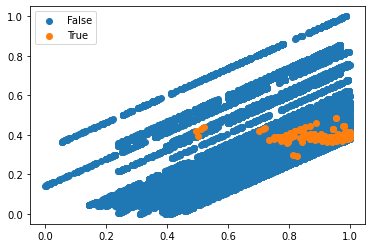

Counter({False: 14210, True: 7105})


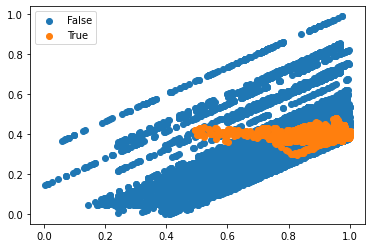

In [131]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over),('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.994957        0.5  0.622222  0.554455  0.59322  0.520446   

   Average Precision  
0           0.313016  

--------------------------------------------------------------------


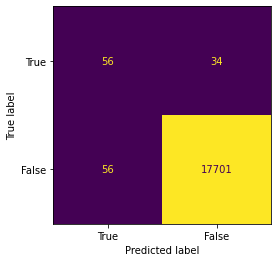

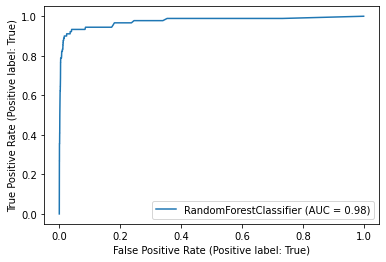

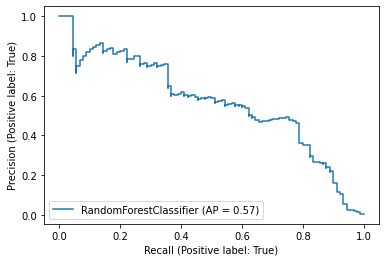

In [132]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# Train the model on training data
rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=[processedData_dealServiceFeatureNames])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

In [ ]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# OLD Model Pipeline - Light GBM

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.995069   0.508475  0.666667  0.576923  0.627615  0.533808   

   Average Precision  
0           0.340664  

--------------------------------------------------------------------


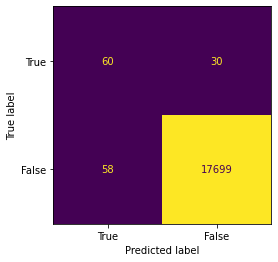

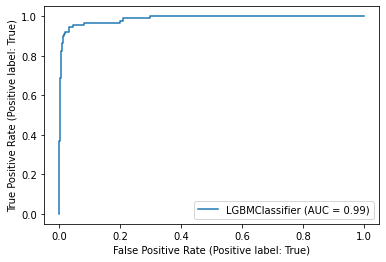

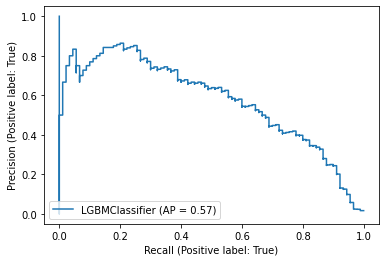

In [133]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier(n_jobs=-1, n_estimators = 3400, max_depth = 25)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

In [ ]:
for i in range(10):

# Model - Pipeline for GXBoost

In [134]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=15,shuffle=True)

# define search space
space = dict()
space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

KeyboardInterrupt: 

In [ ]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

for i in range(25):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
    space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    spaceEmpty = dict()

    GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring=fhalf_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    
    cv_score = optimizedGXBoostModel.best_score_
    test_score = optimizedGXBoostModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)
    
    #feature importance
    importances = optimizedGXBoostModel.best_estimator_._final_estimator.feature_importances_
    for i,v in enumerate(importances):
        print(v)



    #Display the model performance    
    showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 11403.837 seconds
Cross-validation score: 0.7757145444535565
Test score: 0.7812499999999999
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.6, 'classifier__colsample_bytree': 0.4}
0.011394889
0.032656018
0.0261843
0.011768988
0.01651382
0.009361308
0.006273642
0.0036932079
0.005455474
0.011123369
0.0029002905
0.0
0.014173302
0.012430672
0.008337721
0.0066977395
0.0026501494
0.001635374
0.0039611883
0.0043424126
0.027145745
0.02105507
0.0072234552
0.006488641
0.0030079654
0.0005656126
0.005507935
0.011643245
0.019282022
0.004660468
0.0072060893
0.0
0.004

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 10645.227 seconds
Cross-validation score: 0.8024635238998099
Test score: 0.6866197183098592
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.6}
0.008330777
0.03162562
0.020698024
0.013030562
0.015371437
0.0064038807
0.0064802202
0.007551145
0.008831705
0.004262059
0.0
0.0035604883
0.009695109
0.012489432
0.006752067
0.0148933735
0.00067091855
0.0
0.006491136
0.002618051
0.018837098
0.02491297
0.0044596256
0.009030034
0.0035794731
0.0020917575
0.0061061797
0.00497325
0.0012371732
0.014517672
0.0132202115
0.0054617887
0.

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 10837.444 seconds
Cross-validation score: 0.7871390751605445
Test score: 0.7770270270270271
Best Hyperparameters: {'classifier__min_child_weight': 5, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.8}
0.008012398
0.02808484
0.023111546
0.0145934345
0.012760392
0.0040567946
0.004159175
0.0067713195
0.007297424
0.007867958
0.0026758478
0.008564101
0.0084668165
0.011850099
0.0074734846
0.012205152
0.0030444905
0.0
0.003890468
0.0019619633
0.020562125
0.024998084
0.0036575014
0.010710203
0.0034382367
0.0038980069
0.0072637247
0.008326687
0.012440373
0.0066599944
0.0076812296
0.00

# Model - Pipeline for Random Forests

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


pipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=0.1, n_jobs=2)],
                             ['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict() 
space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
space['classifier__min_samples_split'] = [1, 2, 3]


search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedRFModel = search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedRFModel.best_score_
test_score = optimizedRFModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.295 seconds
Cross-validation score: 0.12875831016797748
Test score: 0.1266614542611415
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.937412   0.067782  0.964286  0.126661  0.264533  0.083265   

   Average Precision  
0            0.06553  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.052 seconds
Cross-validation score: 0.12475637359992249
Test score: 0.1437670609645132
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.947274   0.077833  0.940476  0.143767  0.292376  0.095319   

   Average Precision  
0            0.07348  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.174 seconds
Cross-validation score: 0.12895594149037545
Test score: 0.16069699903194576
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0   0.95142    0.08746  0.988095  0.160697  0.322957  0.106959   

   Average Precision  
0           0.086475  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 2.928 seconds
Cross-validation score: 0.1274588139294803
Test score: 0.1396551724137931
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0   0.94408   0.075279  0.964286  0.139655  0.286827  0.092297   

   Average Precision  
0           0.072758  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.793 seconds
Cross-validation score: 0.1352662337826856
Test score: 0.14535901926444836
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.945313    0.07845  0.988095  0.145359  0.297704  0.096154   

   Average Precision  
0           0.077572  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.022 seconds
Cross-validation score: 0.13793292195351764
Test score: 0.1320450885668277
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision   Recall        F1        F2      F0.5  \
0  0.939598   0.070812  0.97619  0.132045  0.274431  0.086938   

   Average Precision  
0           0.069238  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 2.777 seconds
Cross-validation score: 0.13219141024056227
Test score: 0.12887828162291168
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.938645   0.069054  0.964286  0.128878  0.26839  0.084799   

   Average Precision  
0           0.066756  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.107 seconds
Cross-validation score: 0.1334770521366448
Test score: 0.162839248434238
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.955062   0.089245  0.928571  0.162839  0.322314  0.108939   

   Average Precision  
0           0.083206  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.123 seconds
Cross-validation score: 0.12816293923200886
Test score: 0.1275272161741835
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision   Recall        F1       F2     F0.5  Average Precision
0  0.937132    0.06822  0.97619  0.127527  0.26658  0.08381           0.066707

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.068 seconds
Cross-validation score: 0.13650471583242504
Test score: 0.15717092337917485
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.951925   0.085653  0.952381  0.157171  0.314961  0.104712   

   Average Precision  
0           0.081799  

--------------------------------------------------------------------


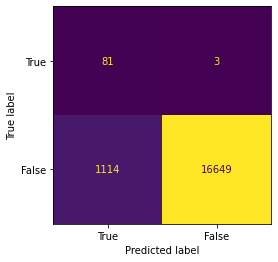

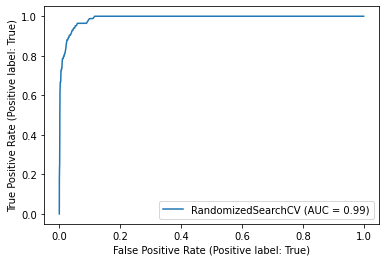

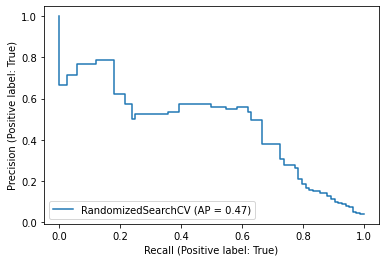

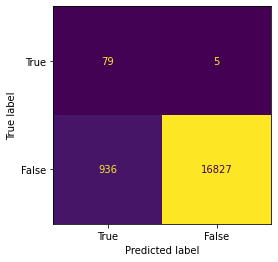

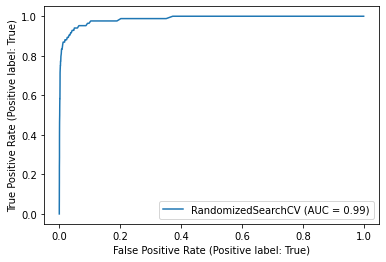

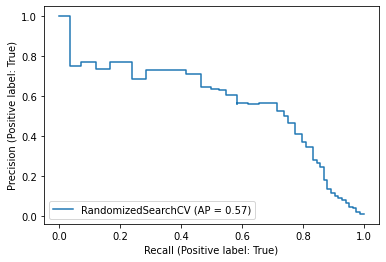

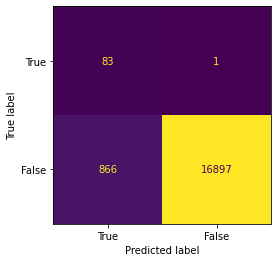

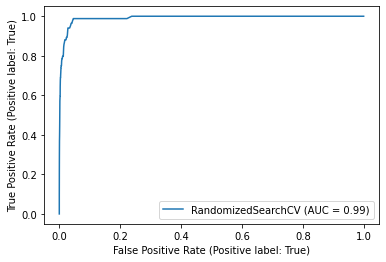

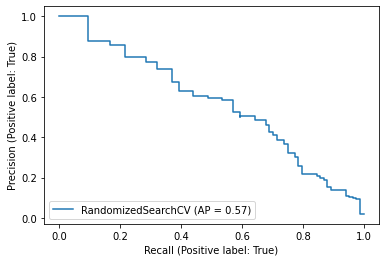

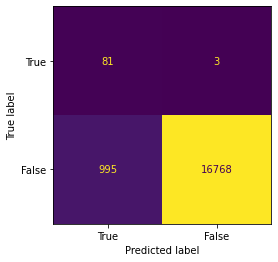

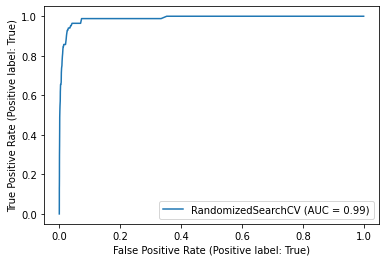

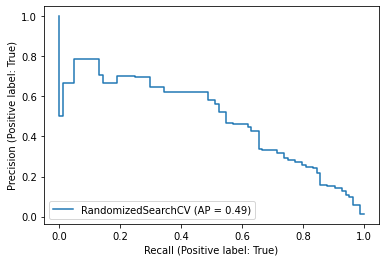

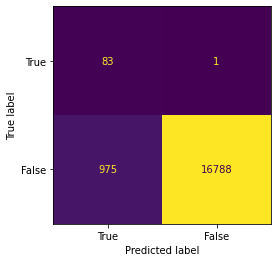

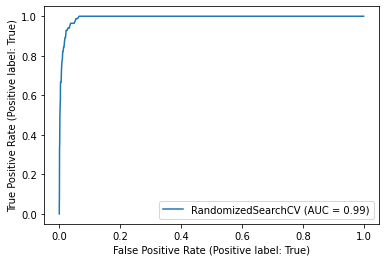

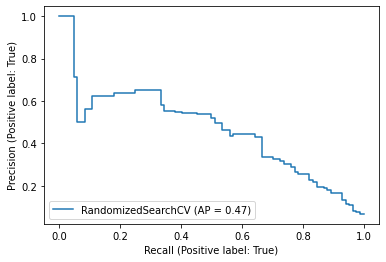

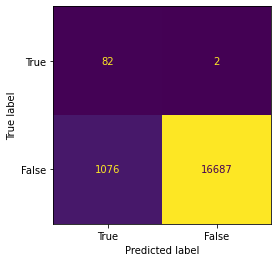

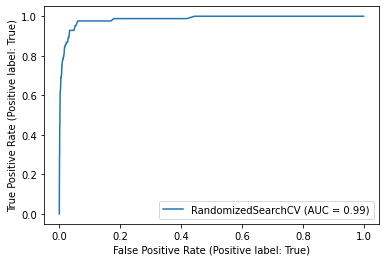

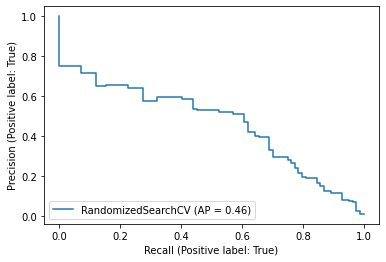

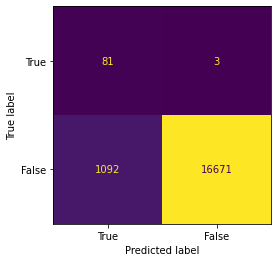

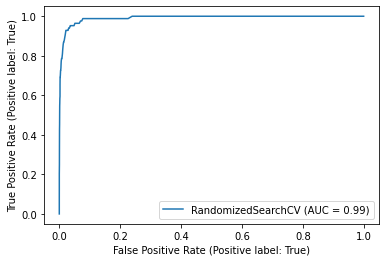

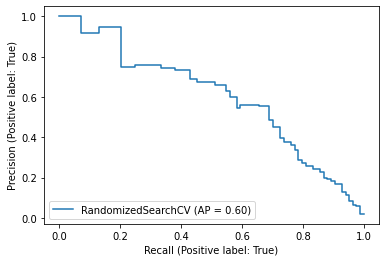

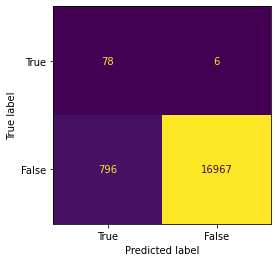

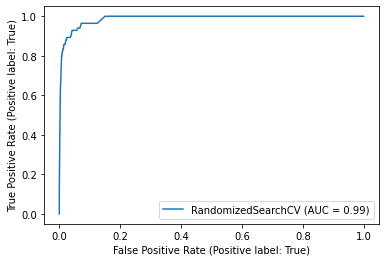

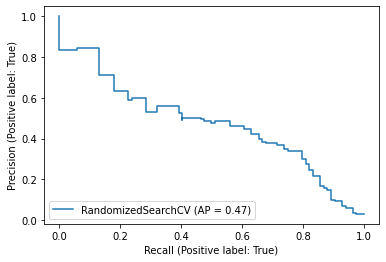

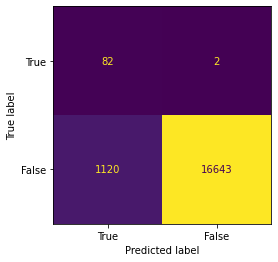

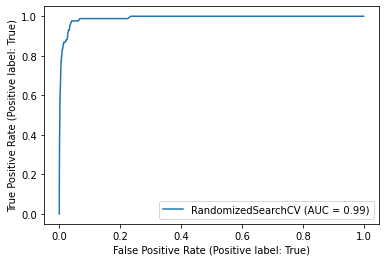

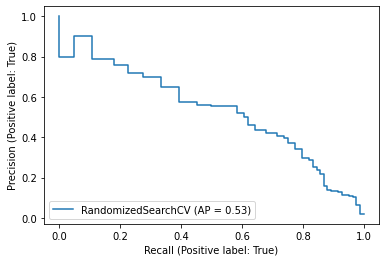

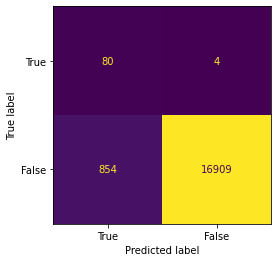

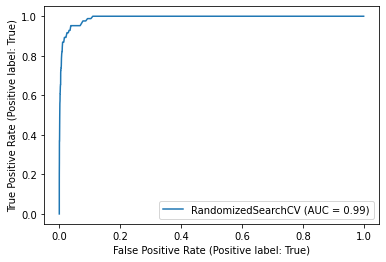

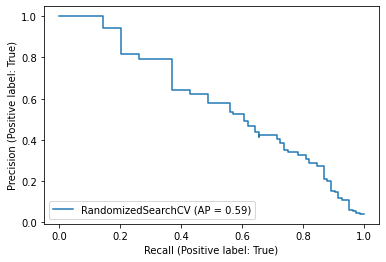

In [172]:
for i in range(10):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    pipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                              ['under', RandomUnderSampler()],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    spaceEmpty = dict() 

    search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

    optimizedRFModel = search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedRFModel.best_score_
    test_score = optimizedRFModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

ftwo_scorer = make_scorer(fbeta_score, beta=2)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


LightGBMPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.1, n_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict()
space['classifier__num_leaves'] = [60, 70, 80, 90, 100]
space['classifier__max_depth'] = [5, 6, 7, 8]
space['classifier__min_data_in_leaf'] = [250, 500, 750, 1000, 1250, 1500]


LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedLightGBMModel.best_score_
test_score = optimizedLightGBMModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67873105 0.69367513 0.6853358  0.7079082  0.55548376 0.69584358
 0.70833598 0.67864134        nan 0.69921927 0.66280706 0.6969368
 0.69731846 0.71591428 0.69016026 0.68558611        nan 0.67331437
 0.68249859 0.70244768 0.69803582 0.7259959  0.72582911 0.71263931
 0.71134802 0.69777551 0.71004305 0.69247943 0.71595027 0.7113969
 0.71851804 0.71106569 0.70390146 0.70240614        nan 0.70005287
 0.70192316 0.70348804 0.67637093        nan 0.70795855 0.70803998
 0.71143025 0.70779368        nan 0.70097395 0.71437738        nan
 0.70551186 0.71675666 0.59642117 0.70367421 0.69156359 0.57007044
 0.69097042 0.72306775 0.71955331 0.70155488 0.71236523 0.70653071
 0.71549938 0.70518491 0.74513984 0.7021784  0.54804802 0.70878382
 0.69422101 0.7131286  0.705

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 3873.547 seconds
Cross-validation score: 0.7451398446007463
Test score: 0.691609977324263
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 700, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.1}
4042.4002734422684
137792.14930927753
236880.63624013215
16634.884904026985
23480.018327355385
551.6208184957504
1008.8600614070892
251.83756053447723
3281.8932353258133
45.88565635681152
939.2849580049515
25.05699050426483
7260.783883213997
14287.069264680147
432.9431099295616
0.0
1006.5319446921349
0.0
195.7087584733963
51.150819540023804
9020.598439216614
978.2203191518784
7598.811386704445
1710.9795731306076
45.952318489551544
51.358139514923096
61.0730699300766
78.58953106403351
82.88628876209259
509.4223520755768
47.06583023071289
94.62457275390625
57.236510

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.68801545 0.69810714 0.6832971  0.66870089 0.69464867        nan
 0.64311669 0.67721834 0.6963009         nan 0.69892133 0.65839243
 0.64170157 0.68555643 0.68037533 0.66676639 0.70325387 0.68228034
 0.67836053 0.68375211 0.66490033 0.68757781 0.6649103  0.70192484
 0.67331032 0.67349533 0.69439309 0.67477991 0.6714271  0.69772675
 0.68545395 0.69199487 0.68891362 0.67618106        nan 0.66095313
 0.65663942 0.6866461  0.65797716 0.67560465        nan 0.70117343
 0.67881284 0.67780804 0.68634667 0.68158939        nan 0.67602423
 0.68906061 0.68155925 0.68763473 0.69812494 0.6829637  0.69894343
 0.68756094 0.70348532 0.68402956 0.66622584 0.68484463 0.689665
 0.65240691 0.67266774        nan 0.69202515 0.69273475 0.68244708
 0.65977569 0.68163714 0.679

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 3294.689 seconds
Cross-validation score: 0.7060185157582544
Test score: 0.7311320754716982
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 800, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.5}
190.01319523661368
33029.686309478675
63947.45512898416
7227.801847876726
3354.049132565844
91.79296561565934
396.05922846953035
230.78367427219928
83.18853576903348
4.432179226154403
146.11965141146356
0.07381689657631796
1640.2025559401118
836.8310823998763
53.23764532859059
0.0
519.2510864244978
0.0
43.06824418302131
36.52489188236359
1372.188611907186
190.93398747544416
1663.9686848430138
6.636955774622038
43.08955412639625
1.8918367008009227
52.96053643025516
62.89599852786205
8.32044100793064
5.345594802041887
3.2651369236409664
25.34179980337649
5.73049235

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69220245 0.69226971 0.68775237        nan 0.62980123 0.66085665
 0.6677672  0.70217402 0.68702065 0.67599404 0.65030915 0.69453332
 0.59165006        nan 0.67567306 0.66682004 0.67792784 0.6843599
 0.69529373 0.68752967 0.68789777 0.6902134  0.59069482 0.68861561
 0.69100172 0.66936311 0.67147373 0.65426697 0.67214984        nan
 0.68753364 0.69616741 0.69499834 0.64872392 0.64803017 0.70037446
 0.68072309 0.64244744 0.64557973 0.67001027 0.67711744 0.69071302
 0.61490112 0.68906447 0.65873331 0.6779112  0.60927528 0.71534157
 0.67749807 0.66797115        nan 0.68281388 0.65886125 0.66314769
        nan 0.66117232 0.68300877 0.65062202 0.65223247 0.70291765
 0.66436586        nan 0.64613853 0.66634081 0.69747746        nan
 0.66331001 0.68666682 0.65

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 3483.242 seconds
Cross-validation score: 0.7153415732991866
Test score: 0.746606334841629
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 900, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.1}
2783.4882920980453
151518.13451439142
235501.97475287318
12313.662519872189
22652.49463737011
194.26758855581284
1675.9907546639442
380.46300077438354
234.19335687160492
35.78785181045532
898.6253893971443
130.9892017841339
6041.235318541527
2270.2664456367493
1713.3686450123787
0.0
837.3346156477928
0.0
233.4727829694748
18.099648892879486
8759.985351860523
1337.9108154773712
4822.141409635544
65.73225176334381
139.2645159959793
16.136801779270172
258.72437739372253
752.0482153296471
57.861564576625824
55.78711009025574
61.35644030570984
2.902046024799347
43.7164

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70203736 0.70482069 0.68204145 0.69506767 0.71055615 0.71518669
 0.71631523 0.71084909 0.69126592 0.69529689 0.689754   0.71238603
 0.71258    0.68640886 0.72454386 0.72425774 0.69303008 0.69653489
 0.68820159 0.66900036 0.7018452  0.69184369        nan 0.72370113
 0.72044349 0.71250878 0.70489842 0.69390704 0.71499895 0.712673
 0.72516688 0.70883023        nan 0.71590458 0.71033316 0.68915015
 0.69925057 0.71968193 0.69956586        nan 0.67227302 0.72347005
 0.71107537 0.69670904 0.67486473        nan 0.71035848 0.6858844
 0.70342895        nan 0.69192674 0.68529793 0.70384421 0.68075948
 0.71151222 0.67133958 0.70167975 0.6940008  0.71986885 0.70626544
 0.71990696 0.71027574 0.71356249 0.69326146 0.72337353 0.70415303
 0.70276133        nan 0.7011

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 3513.870 seconds
Cross-validation score: 0.7279301232034671
Test score: 0.7125890736342043
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 800, 'classifier__max_bin': 255, 'classifier__learning_rate': 1.0}
989.576102321158
17105.960301936928
44224.168254013595
4461.573176101658
1470.3987890418975
47.17365297221113
228.43059782510318
103.34900794374335
93.25373123958707
2.0219312132394407
16.916232996154577
20.11903615335177
607.2286928610883
5923.529495367613
169.43226224009413
0.0
579.2987810475752
0.0
8.356363833470823
13.798167718949117
2180.914952305473
97.37614075503006
343.8527935626789
986.2291546985361
10.97212843374291
3.0577854104340076
122.11312368298968
225.0156454279786
0.011208117357455194
14.580865863608778
0.0018444990491843782
0.10825827403823496
1

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70132532 0.72012559 0.69183475 0.68159931        nan 0.66626086
 0.6857619         nan 0.69505032 0.71087075        nan        nan
 0.69091012        nan        nan 0.68140507 0.68442298 0.70038509
 0.68009736 0.68339792 0.68604559 0.68271166 0.68953921 0.67872806
 0.67664057 0.68856774 0.69057784 0.7064815  0.68588284 0.71424449
 0.69400847 0.67182373 0.63647687 0.69872048 0.66756815 0.67474049
 0.67000563 0.66333929 0.66915088 0.67924048 0.6458887  0.67890823
 0.70616985 0.70152016 0.6828713  0.66979366 0.68019454 0.70619033
 0.68621757 0.62163367 0.68798726 0.6809799  0.71467021 0.67251638
 0.68292915 0.6870401  0.66996435 0.68591787 0.68683027 0.69756532
 0.69146111 0.72278446 0.66824744 0.69663242 0.70553244 0.65955779
 0.70523771 0.6955634  0.6

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3450.718 seconds
Cross-validation score: 0.7227844560042576
Test score: 0.7488479262672812
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': -1, 'classifier__max_bin': 500, 'classifier__learning_rate': 0.3}
1310.763629437366
53175.67648664769
87580.66816881593
4936.454786751361
9335.695764376724
31.826771178515628
153.5690964133246
59.83631796611007
49.23343201272655
9.813317752268631
228.54480097821215
0.05880400165915489
1439.8161481113057
2977.5724866190576
111.16347360855434
0.0
251.5756196451257
0.0
20.645530070061795
2.055679768061964
2504.0617890093126
461.78904978663195
2911.935559789883
917.9544995943143
38.4270992919337
3.617081944248639
23.659190386359114
132.77298952220008
42.02025407226756
36.88224541279487
49.371477110194974
16.16759957629256
35.4455057

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.69965304 0.70893474 0.71803548 0.71035754 0.68775718
 0.70648813 0.70732938 0.70653242 0.70963834 0.71977848 0.69017347
 0.72510387 0.7066955  0.71495416        nan 0.69885214 0.71152518
 0.71957623 0.69658462 0.70346045 0.70237819 0.72740063 0.70715412
 0.73042331 0.69568913 0.70421825 0.61451961 0.68839314 0.70219327
 0.6912737  0.68855088 0.68996459 0.68121766 0.68155442 0.69811138
 0.71464035        nan 0.7392354  0.69248513 0.69480462 0.71143415
 0.70269    0.69634435 0.73677622 0.66787057 0.71607044 0.70984259
 0.72290019 0.70837802 0.71867521 0.69772513 0.69071852 0.69308776
 0.71788339 0.7130824  0.7222904  0.69399681 0.70956277 0.70050585
 0.70090719        nan 0.71766227 0.69858144 0.68570753 0.71077365
        nan 0.73044177    

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3526.052 seconds
Cross-validation score: 0.7392354044694049
Test score: 0.6610576923076923
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 400, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.7}
198.30314110860309
30724.768019813568
48018.3778337463
2163.3815292423533
4497.427898266396
36.08530720059571
91.16499867418315
6.928534815553576
2.6388086889637634
82.98324892969686
6.984540104866028
7.691644761558564
828.59960921327
561.0817275748414
272.2873236507221
0.0
58.1511366131017
0.0
22.200123928952962
2.842688156175427
2564.4831023001934
196.2779855042172
1922.8166730751836
35.44967759651445
8.666694104729686
11.01116359536536
5.952303547950578
2.9942083951209497
8.609079668531194e-05
4.160380214772886
24.372267280559754
1.2811739678982121
78.62419553

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.66181483 0.5930709  0.68001861 0.68854831 0.67933822 0.69099219
        nan 0.67429379 0.71179971 0.70709462 0.70524918 0.67151663
 0.6534021  0.67356538 0.43637059 0.67475206        nan 0.60685758
 0.70110753 0.7075487         nan 0.7001353  0.69554098 0.68180238
 0.69097186 0.67516677        nan 0.69403963 0.6975411  0.69080174
 0.69544571 0.68947829        nan 0.68800077 0.69192357 0.67126126
 0.68843326 0.61268302 0.66849618 0.70223523 0.6901891  0.69679539
 0.54201746 0.67806641 0.70909893 0.67057603 0.67551421 0.69508495
 0.67300033 0.68295675 0.66190844 0.69790267 0.62923206 0.65418775
 0.70571932 0.68263148 0.67404125 0.69356614 0.66026149 0.66234348
        nan 0.68675527 0.70380195 0.70267719        nan 0.69111911
 0.69049222 0.66948053 0.6

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 4049.319 seconds
Cross-validation score: 0.7134317849901947
Test score: 0.7062780269058296
Best Hyperparameters: {'classifier__num_leaves': 26, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': 100, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.1}
2392.4446382522583
120366.765468359
240413.59669411182
18902.921875953674
19001.88786673546
3975.997059583664
402.69784784317017
152.3717176914215
384.1818952560425
69.66747903823853
15.187499761581421
6.092199802398682
9533.74962759018
18797.56282186508
1422.9032979011536
0.0
2789.767534971237
0.0
574.6108770370483
40.26399898529053
8153.615362882614
5694.842065215111
6863.647039175034
681.0884237289429
76.60220050811768
4.064839839935303
261.46748065948486
2416.2786288261414
629.5963969230652
1024.3780624866486
61.1924991607666
58.797119140625
39.37377023696899

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72101134 0.69382866 0.72722808 0.71353755        nan 0.71663792
 0.71039437 0.44135322 0.73346575 0.70209254 0.70978397 0.72270568
 0.71932373 0.72739754 0.71916359        nan 0.72318274 0.71082877
 0.75900275 0.72600896 0.72055719 0.65806355 0.6944157  0.71269344
 0.729907

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 4000.911 seconds
Cross-validation score: 0.7590027450093066
Test score: 0.6323185011709602
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 200, 'classifier__max_bin': 500, 'classifier__learning_rate': 0.3}
1188.7853308406684
43905.49650288843
94288.16779517054
7969.378897403032
4458.671648818723
312.7961964858114
115.30578569414226
19.468814674328314
13.294689585556625
124.19237925287553
361.4223880349309
53.89358271700621
2970.583814957805
5778.695732018336
242.40547668894578
0.0
1118.0390512325612
0.0
54.24095871589088
5.190659591928124
3447.7588244316685
2656.358913026692
3483.815837535498
62.68505813875527
11.46985331986798
10.305170466424897
124.97314156912034
248.12041977934132
3.312113035673974
115.61750758485869
14.821721790824085
10.114871933154063
16.3095

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70482468        nan 0.69642984 0.71568504 0.71771037 0.72593773
 0.72344924 0.72126875 0.7111772  0.71254405 0.72055483 0.70783354
 0.70348172 0.71094569 0.70913522 0.72711055 0.71533877 0.71398797
 0.68453737        nan 0.70376197 0.70156616 0.71948618 0.74190838
 0.72370257 0.71850188 0.72747565 0.68222817 0.70076152 0.69688636
 0.70523297 0.70506846 0.52793056 0.70378893 0.6998211  0.71276109
 0.70621295 0.70497752 0.71993783 0.68996281 0.72841261 0.70543287
 0.71965212        nan 0.73660714 0.73946973 0.71665779 0.69812059
 0.71377089 0.72154021 0.71553357 0.72365895 0.70381622 0.71117198
 0.6963778  0.6875213  0.70853132 0.72268828 0.72104039        nan
 0.68853712 0.70829092 0.72545629 0.68977078 0.71448876        nan
 0.72677204 0.70601794    

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 3667.923 seconds
Cross-validation score: 0.7419083801010167
Test score: 0.667447306791569
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 800, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.4}
299.0264628373334
38943.587914318225
76054.76241188397
8167.549209411765
5540.08702773157
147.85354889804148
77.1608065560431
81.19488133257255
49.40300389634649
151.02190061612055
20.716318186357967
3.2051361800695304
1950.2041394393164
320.5426308044698
1303.6399282651837
0.0
102.3350177386892
0.0
238.35776105539117
24.565176251460798
2605.2407881815307
72.78183982874907
858.6281430171148
447.9642789365462
0.09201103879604489
4.461606751196086
75.1293819963903
38.01639820885612
24.33875283692032
14.798532011918724
25.006518421927467
10.837656438350677
99.3150523

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71161994 0.66777142 0.6689152  0.67850578        nan        nan
 0.67150977 0.70389022 0.64320533 0.69283759 0.70128998 0.66367047
        nan 0.66791726 0.67971665 0.68693189        nan 0.67594606
 0.68939766 0.6940021  0.69603748        nan 0.65229745 0.67105724
 0.69390237 0.68800724 0.70659792 0.68252057 0.68557819 0.68912323
 0.67729721        nan 0.69162243 0.67384959 0.69250267 0.67960391
 0.66303829 0.70384068 0.6960585  0.69312522 0.68106021 0.69948799
 0.67920663 0.67901262 0.67154684 0.67582858        nan 0.68968488
 0.68438122 0.69088416 0.68021929 0.72217703 0.68437586 0.68653099
 0.65664527 0.70561993 0.66785315 0.68205117        nan 0.68924919
 0.69501542 0.65456531 0.68587626 0.64677415 0.70050075 0.68797961
 0.6882188  0.65778524 0.6

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 3167.100 seconds
Cross-validation score: 0.7221770325468807
Test score: 0.6995412844036697
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 200, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.2}
4084.3853324502707
59660.16604569554
128859.65449908376
10240.280052274466
16305.744093805552
187.6213056743145
99.94259941577911
98.92743530869484
559.2998306453228
7.51987612247467
445.5726578235626
4.4490620493888855
4942.403762355447
4116.829931378365
175.68855023384094
0.0
759.6848427653313
0.0
232.4499707520008
18.28946018218994
3448.7753134071827
1210.7902640998363
3578.003883242607
926.6132224202156
49.202912241220474
33.395391672849655
128.9000340104103
367.1349256336689
5.577449798583984
274.95410346984863
3.5510900020599365
73.83982628583908
84.6482556

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69300374 0.69089025 0.68968283 0.71039756 0.67853765 0.68029048
 0.69123892 0.68902407 0.69092311 0.70021091 0.72307204 0.69640005
 0.69550252 0.62455399 0.68364811 0.70880931 0.70545679        nan
 0.71737707 0.69490115 0.70447606 0.71216552 0.6999001  0.69319909
 0.70546823 0.70938066 0.72121317 0.70508879 0.69437003 0.71950285
 0.71008234        nan 0.69624974        nan 0.70532557 0.6878007
        nan 0.6888072  0.69050355        nan 0.70265077 0.696246
 0.71770482 0.72059009 0.69741939 0.69870402 0.70584815 0.67779534
 0.72594199 0.69042209 0.71371301 0.68867173        nan 0.71217089
 0.71061257 0.70887487 0.68923674 0.69152002 0.67662859 0.69442719
 0.68647606 0.70897101        nan 0.67528121 0.70751294 0.6937481
 0.71072615 0.7077517  0.70144

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 3156.541 seconds
Cross-validation score: 0.7260776474887504
Test score: 0.7272727272727273
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 300, 'classifier__max_bin': 100, 'classifier__learning_rate': 0.3}
1638.224349864875
49732.53220175055
85639.50072572217
7553.48758437403
7490.445227773045
173.62916074530222
79.02523304335773
60.902646405855194
60.4698401640635
44.18955060420558
100.79691610019654
5.131610919488594
3661.270875859889
4194.198654609965
266.55004128289875
0.0
1251.9434998829383
0.0
49.99384809518233
22.70533948764205
4827.467106097611
576.1738391758408
3183.709130884381
128.21655261702836
2.030430984683335
122.12309837341309
45.746301334002055
214.84246676182374
25.732363981194794
298.7231848347001
29.716167770326138
8.075349386781454
210.00683956

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69397324 0.71398566 0.68442479 0.73728504        nan 0.71209029
 0.71502215 0.67879372 0.70344241 0.73284105 0.71097599 0.6936515
 0.72578779 0.72166921 0.70679128 0.73575091        nan        nan
 0.71973811 0.720491   0.70913566 0.70328148 0.70447586 0.72405132
 0.72108191 0.71294231 0.69080362 0.71882776 0.72359359 0.73605131
 0.70981078 0.70383377 0.70648086 0.72161197 0.6972768         nan
 0.69027162 0.70116063 0.70982389 0.6688799  0.708019          nan
 0.71412664 0.70855151 0.71419654 0.67968441 0.70076922        nan
 0.70831332 0.67923007 0.68937741 0.74246725 0.72117755 0.67578829
 0.72103617 0.71510713 0.70910982 0.7160536  0.72646248 0.70474471
 0.74124928        nan 0.67348287 0.70390392 0.74198451 0.70731945
        nan 0.7051431  0.72

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3112.346 seconds
Cross-validation score: 0.742467245180051
Test score: 0.746606334841629
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 200, 'classifier__max_bin': 50, 'classifier__learning_rate': 0.3}
761.0034013906843
57739.80917955199
84812.14919121814
4278.74256899266
10628.617270157032
72.96366837329697
96.83302874318906
96.0961812105379
348.2116854118649
6.4154199762269855
89.43038419249933
0.6748449626029469
1387.1883884069102
2692.977812924335
201.22885530383792
0.0
219.26637349376688
0.0
38.87665238918271
40.70365000329912
2950.4593857889995
470.3260759280529
3213.0396220407565
548.9555570866796
366.5668644887628
22.82669407367939
59.76481773506384
33.26028127496829
0.49732647952623665
34.063043464906514
0.12952983297873288
0.4459905184339732
32.340511640

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70771217 0.69794997 0.67501212 0.66543105 0.67500472 0.68270308
 0.68294188        nan 0.69787129 0.69594225 0.69402139 0.68803736
 0.69424316 0.70436324 0.70663815 0.69059639 0.69436236        nan
 0.6811601  0.72135577 0.69758568 0.68537043 0.68546296 0.67801462
        nan        nan 0.71785642 0.64758583 0.69971665 0.68381287
 0.66151604 0.68865414 0.66045941 0.71515586 0.69899885 0.68854912
        nan 0.71018764 0.70773924 0.70048312 0.67917462 0.69372521
 0.68917195 0.72959188        nan 0.69198347 0.66636348 0.69571455
 0.69502034 0.70956029 0.68111474 0.71582475 0.69480383 0.70382241
 0.68743957 0.6769046  0.70784007 0.70768928 0.69621646 0.7165571
        nan        nan 0.67429819 0.55066027 0.69800363 0.6800987
 0.68817077 0.68296883 0.719

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 3346.094 seconds
Cross-validation score: 0.7295918829048528
Test score: 0.6864988558352403
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 100, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.1}
971.2874864935875
131155.85730816796
249994.42442807555
18190.21811656654
13846.435441106558
106.95543336868286
82.25402149558067
379.332712829113
122.15895074605942
468.50101132690907
621.8553628008813
11.526749849319458
8520.920590519905
16285.95875659585
1000.7432037368417
0.0
1358.3794133663177
0.0
123.08058974146843
54.77614462375641
9456.184713721275
885.0604391098022
6653.025163114071
295.8690382242203
56.66018480062485
0.0
105.7446710318327
351.1819884777069
138.16205874085426
582.094722867012
106.15813076496124
24.559290409088135
57.95091950893402
523.26

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.71218961 0.70536279        nan 0.71541386 0.72767424 0.71111178
 0.73198481        nan 0.68494858 0.70743731        nan 0.70917302
        nan        nan 0.70035361 0.71807012 0.70801008 0.7438383
 0.71409005 0.71387857        nan        nan 0.73720298 0.7222763
 0.69926386 0.72647947 0.72372083 0.72131546 0.72323715 0.71994459
 0.7394589  0.7096777  0.72536396 0.71182469 0.71082378 0.72634921
 0.69829914 0.64098011 0.74080433 0.71950121 0.71324526 0.72303455
 0.70886464 0.72226372 0.48176355 0.72754596 0.7142403  0.7113577
 0.70980973        nan 0.72645304 0.7315089         nan 0.73764356
 0.72714569 0.70236066 0.70883402 0.71372248 0.72118803 0.7193336
 0.70912733 0.69441889        nan 0.71918914 0.7149162  0.72170451
 0.71899733 0.69178793 0.73970

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 3091.716 seconds
Cross-validation score: 0.743838304485755
Test score: 0.6220657276995305
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 700, 'classifier__max_bin': 100, 'classifier__learning_rate': 0.6}
1093.592282006597
22916.259503368274
53294.881938989056
6402.9410714919395
4162.721111120911
89.38548875431297
68.10400881687747
258.1930776257359
52.64837551904202
2.1475787093841063
71.53226288408041
10.489174458474736
1275.8516503985084
5211.134994565575
193.65865629687323
0.0
323.51600112440065
0.0
100.42128172372031
2.404117385391146
2276.4046482995036
2145.3962225836585
2259.7727478779925
5.137206411163788
5.513226193594164
0.0026912700850516558
33.226880040136166
88.04601579597511
1.0915913135395385
291.95181965170195
0.003305109916254878
10.280000915256096

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.68864937 0.68589716 0.67254926 0.66458237        nan 0.69171705
 0.67488045 0.66294063 0.6839196  0.66765983 0.64328076        nan
 0.65695536 0.67266207 0.68449959 0.67675048        nan 0.66740065
 0.65581325        nan 0.6655154  0.6823009  0.67606035 0.70189277
 0.68127938 0.66864989        nan 0.67797914 0.68552799        nan
 0.66759574        nan 0.70185506 0.68501921 0.67796748 0.67961567
 0.66920814 0.65435596 0.69597081 0.65973597 0.69806105 0.66338932
 0.67286504 0.68983428        nan 0.67410853 0.69272563 0.67528995
        nan 0.66192386 0.67593553 0.66536043 0.68443996 0.53719694
 0.67319813 0.68002762 0.60563751 0.68820688 0.67861191 0.70616783
 0.6574389  0.68405917 0.67817126 0.67009189 0.69022944 0.6777552
 0.67967109        nan 0.67

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3055.140 seconds
Cross-validation score: 0.7135705958269687
Test score: 0.7568807339449541
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 600, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.3}
639.1702614238166
43305.155269132534
97347.41002699634
5375.642274763857
5512.245215748211
261.5126391458034
367.9314695214998
144.97417201209464
241.93150413892
166.54292382617132
154.29152092008735
99.50160241717822
1797.0338015809539
8494.83531325472
506.1021898621177
0.0
210.04849822782853
0.0
112.09532866082736
16.45144002897723
2100.9442607742385
214.13299734235625
4203.735355122364
709.2741403214986
6.1234447407478
23.063489029038465
161.99979330991482
87.41239961838437
34.37017429883417
1.6224552542844322
36.86591239160043
0.9542378313199151
163.210424449

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.70126181 0.67949381 0.69909469 0.69161796 0.6926027
 0.68753436 0.7067082  0.69623187 0.67817951 0.69579135 0.71134834
 0.69426286 0.69232239 0.69193595 0.71251187 0.68150063 0.71892918
 0.67559471 0.67600739        nan 0.70633584 0.70869619 0.69675957
 0.70356736 0.68378875 0.69032026 0.68151791 0.70901678 0.68790768
 0.69876922 0.70400845        nan 0.70810511 0.69575257 0.71540165
 0.68405782 0.67650394 0.71181439 0.68216307 0.69165372 0.67525332
 0.69143543 0.70415592        nan 0.68614095 0.67076166 0.6907379
 0.71292531 0.69986579 0.70461493 0.68853365        nan 0.68749961
 0.68164387 0.70226467 0.68762793 0.67862378 0.67649041 0.68678739
 0.68560854 0.68265296 0.66115019 0.70493464 0.70801717 0.68624296
 0.67996439 0.68438285 0.695

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 3245.405 seconds
Cross-validation score: 0.7189291830717466
Test score: 0.7603686635944701
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 400, 'classifier__max_bin': 100, 'classifier__learning_rate': 0.2}
1279.615401298739
77556.0842593601
121304.29628536291
8818.586007429287
11522.524166543968
140.29836437571794
1041.0267278552055
39.68658720608801
73.6811864823103
51.95907970890403
289.56521427910775
5.190055754035711
4549.536396466196
2400.7435111496598
812.8096073195338
0.0
924.9820347400382
0.0
67.93015277013183
36.189263368956745
3408.7275485601276
1272.1799558484927
4100.4599146666005
50.7146286489442
15.448961632326245
21.11492013093084
70.84122954402119
971.1713294871151
7.930010914802551
21.06611137278378
16.120712906122208
13.366298101842403
2.800099384

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.68912656 0.68198284 0.69928484 0.66187632 0.68186588 0.67540455
 0.67208815 0.68828076 0.68651255 0.65285202 0.67396778 0.6823932
 0.64245232 0.67175643        nan 0.66977004 0.6840353  0.68080787
 0.69064721 0.66103442 0.67507197 0.68057412        nan 0.67877587
 0.67923127 0.6840675         nan 0.66402125 0.68033833 0.68240016
 0.66689161 0.68553568 0.68913676 0.68089919 0.59986175 0.66289392
 0.68770214 0.6817797  0.67244172 0.67244302 0.68222025 0.64724765
 0.69030394        nan 0.69102216 0.63048171 0.6832043  0.6267512
 0.67418116        nan 0.68956503 0.6898559  0.66564425 0.69020144
 0.65169622 0.67536262 0.68332614 0.66483155 0.68809467 0.68942342
 0.66937365 0.68737472 0.65821926 0.68254597 0.64996424 0.67519837
 0.66743581        nan 0.695

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
Elapsed time to compute best fit: 3223.246 seconds
Cross-validation score: 0.7088822715352615
Test score: 0.7175398633257403
Best Hyperparameters: {'classifier__num_leaves': 51, 'classifier__min_data_in_leaf': 900, 'classifier__max_depth': 100, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.1}
1113.0834940869877
117693.88327762522
247695.93795362464
17193.467354529465
15321.331155601787
171.72145708053176
169.9482807694003
254.8459675774211
101.73169962503016
149.98204972525127
307.5280125439167
22.414553639362566
8916.234817791032
24168.158284949615
962.5395840298152
0.0
1877.1188390799798
0.0
403.5931451157667
81.46102391404565
8501.213270795706
8882.869702004224
6680.612138768047
451.0599986643392
44.03148028276337
19.816300694132224
112.28886773949489
111.32958736782894
34.40932312564837
839.4294360681342
44.7242623870261
80.62106379121542
94.18534

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67877145 0.69779215 0.69369822 0.68348474        nan 0.68077439
        nan        nan 0.63684651 0.64993454 0.66678127 0.64467763
        nan 0.65536437        nan 0.68463072        nan        nan
 0.68379743 0.68939806        nan 0.68461507 0.69595351 0.70838969
 0.70023604 0.67435506        nan 0.70251817 0.69069848 0.70581773
 0.68897814 0.69344235 0.69498087 0.6877464  0.70344973 0.68857723
 0.67899979 0.68645641 0.68236468 0.69866042 0.66704742 0.68568189
 0.60736692 0.67837276 0.69026966 0.67533963 0.69176155        nan
 0.69400568 0.68564869 0.65088159 0.68030282 0.68038122 0.70632714
 0.69151433 0.66707753 0.67730449 0.53385395        nan        nan
 0.69892201 0.69935793 0.67645851 0.70267355 0.68373698 0.65306801
 0.67168341 0.68863472    

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 2977.184 seconds
Cross-validation score: 0.7158427653831854
Test score: 0.6979405034324943
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 100, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.1}
1144.484290421009
154916.7736942172
230096.37327337265
14851.5258538723
27187.92596554756
127.94185036420822
27.83109998703003
188.13029968738556
276.1457920074463
355.4817593097687
444.2500855922699
91.25508999824524
6656.028096795082
3404.860591709614
2826.1469442248344
0.0
1664.9409911632538
0.0
104.7504488825798
75.58067810535431
12642.486809968948
1730.3181618452072
5380.891856789589
669.0563259124756
246.99446541070938
2.5736500024795532
69.21936982870102
45.2988845705986
261.23241662979126
346.0267983675003
195.87309765815735
15.79053020477295
36.444609761

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70073543 0.69150043 0.70128445 0.71071476 0.7041013  0.71515733
 0.67429593 0.72472631 0.71737759 0.718431   0.72404062        nan
        nan 0.7102864  0.68059709 0.72467515 0.67906929 0.7045193
 0.69004825 0.69778251        nan 0.71908771 0.70550684 0.70600203
 0.7227357  0.70589419 0.71429277 0.72626668 0.70997617 0.71313357
 0.68359565 0.71981775 0.71928147 0.69923139 0.70877465 0.70873627
        nan 0.68713622 0.70055541 0.69040099 0.69986276 0.56574064
 0.71281661 0.73470884 0.70950334 0.69341541 0.71506417 0.71218457
 0.67924458 0.72355972 0.71954773 0.69913359 0.6747403  0.70898158
 0.71921374        nan 0.71841687 0.71811715 0.71073892 0.69160041
 0.70871402 0.71048313 0.73635078        nan 0.68051653 0.70806871
 0.70401491 0.70174751 0.72

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 3354.078 seconds
Cross-validation score: 0.7372160437788916
Test score: 0.735981308411215
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': -1, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.3}
694.5110489178915
54686.01790108229
86594.86893027788
6501.405582366278
7383.1176382568665
266.19659522059374
60.31993444473483
72.91938304202631
91.63884274638258
2.141825212398544
69.18035515025258
4.691878054756671
2330.0327457843814
2714.1339086510707
1057.868906010408
0.0
363.34981906739995
0.0
84.48054899019189
33.90058714454062
5552.99714056449
741.285690522287
2382.7231580750085
81.94885901315138
22.36593707278371
13.792869377415627
47.858708776533604
38.23451153980568
163.06252336502075
61.63722673943266
11.092487089335918
3.7699109613895416
35.89115878893

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70614325 0.64975845 0.65788785 0.67865817 0.67408814 0.68562025
 0.6703932  0.66784806 0.69903836 0.68651799        nan        nan
 0.68442919 0.67405547 0.70200333        nan        nan 0.64973887
 0.66065519 0.67754214        nan 0.66659677 0.68315962 0.68435735
        nan 0.70609326 0.66266395 0.67750095 0.60378015 0.67471372
 0.67283718 0.68631853 0.68729494 0.65750965 0.65757257 0.67614066
 0.6777597         nan 0.6906386  0.70358463 0.68753533        nan
        nan 0.68799543 0.670898   0.67271878 0.66960394 0.66190764
 0.69230048 0.68085895 0.66134547 0.66244182 0.70433352 0.67407317
        nan 0.69276389 0.68785323 0.66802374 0.69504374 0.66329507
 0.65370961 0.68367833 0.67873937        nan 0.66684966 0.66697589
 0.64067213 0.68174932 0.6

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3023.493 seconds
Cross-validation score: 0.7061432499386642
Test score: 0.7517084282460137
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 100, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.4}
2797.4407410770655
33475.48144707084
70055.4429371506
7028.418218817562
6050.897294770926
61.17191766947508
70.35157069191337
576.9530955031514
16.967416003346443
81.50100197643042
14.839003585278988
0.7321738004684448
1618.6699180826545
6258.836154051125
478.2089421376586
0.0
446.62775549292564
0.0
122.79161985963583
10.907046243548393
2427.204695634544
1169.5595183484256
888.7293920665979
6.956805989146233
4.421830056235194
5.733083210885525
1.4064686745405197
656.7203475534916
45.098209381103516
14.774519920349121
2.618712067604065
2.3414169549942017
10.202645

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69484315 0.69828272 0.69849037 0.704178   0.69770063 0.7017948
 0.71062323 0.70314119 0.68847701 0.71119793 0.68609684 0.71080323
 0.69685735 0.66171438 0.6880027  0.68681064 0.71883753 0.71237152
 0.70057037 0.7043723  0.70044896 0.67658528 0.70610153 0.69776753
 0.69035118 0.69829557 0.68754001 0.70328026 0.65040102 0.68199627
 0.70963012 0.67047462 0.70223945 0.6755326  0.68412408 0.68737346
 0.68910658 0.72219232 0.69776714 0.71974923 0.72153123 0.69994457
 0.69460471 0.71518816 0.68083667 0.71428644 0.69254115 0.66992905
 0.71072239 0.7140097  0.71211974 0.69072756 0.7082582  0.69587532
 0.69414773 0.69740031 0.67140347        nan 0.70828125 0.43600249
 0.71463624 0.70572283 0.69163152 0.71655746 0.72375796 0.71075273
        nan 0.68383374 0.70

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3626.711 seconds
Cross-validation score: 0.7237579595402464
Test score: 0.7641921397379913
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 600, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.3}
1166.9453198462725
47730.98636814207
88955.14497881383
7623.8108385279775
5045.639876529574
13.742499381303787
15.680290341377258
84.58161595463753
18.7999996393919
117.00964660197496
28.950291864573956
39.067277394235134
2754.43479809165
6062.542600847781
79.70835939049721
0.0
606.9559733569622
0.0
8.854797974228859
1.4954130053520203
4331.502898707986
357.1332154273987
5617.778894662857
76.9226990044117
61.525008514523506
6.220504939556122
26.392780601978302
2.144597962498665
9.211770176887512
232.4886587932706
0.0
14.060202181339264
8.441667079925537
161.06668

exception calling callback for <Future at 0x299d02ca760 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\joblib\parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\joblib\parallel

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


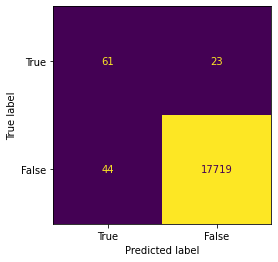

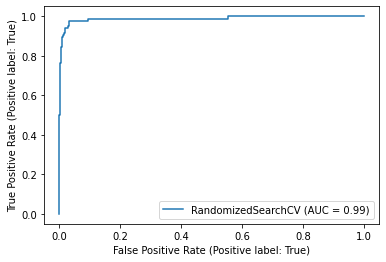

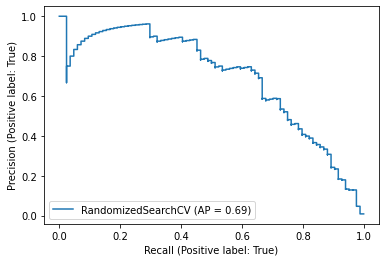

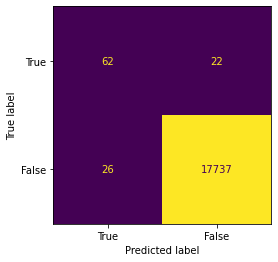

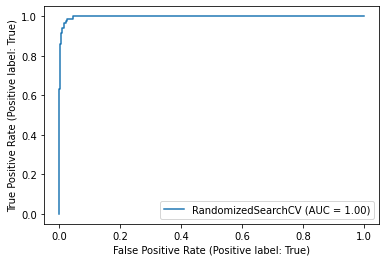

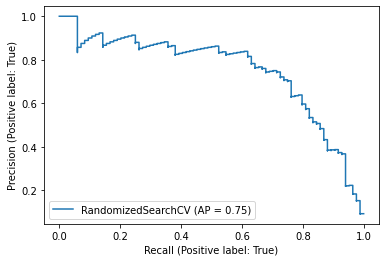

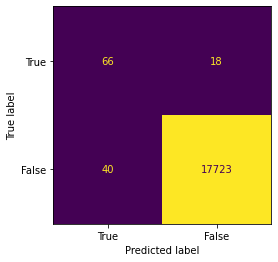

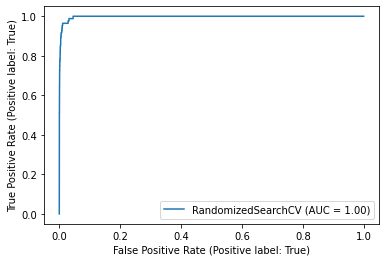

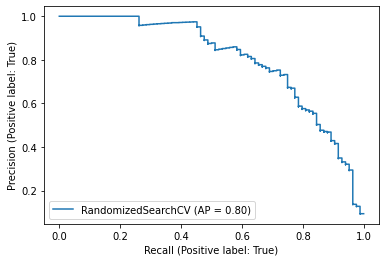

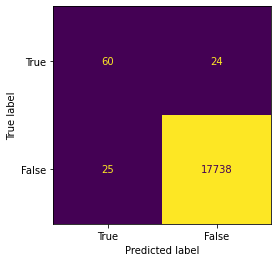

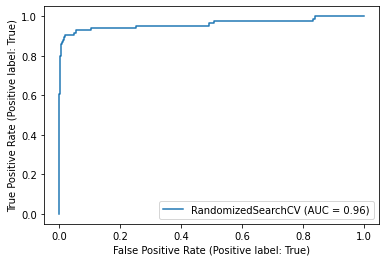

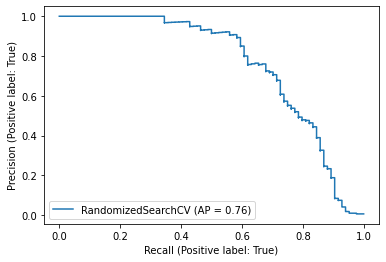

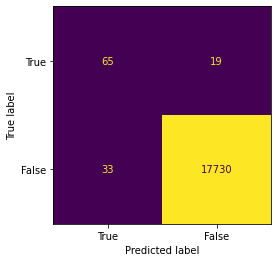

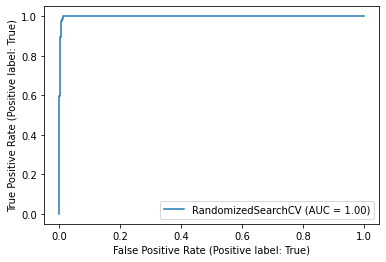

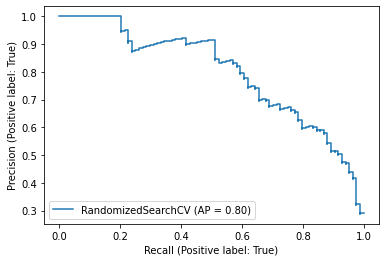

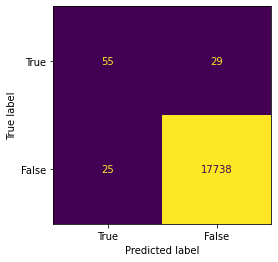

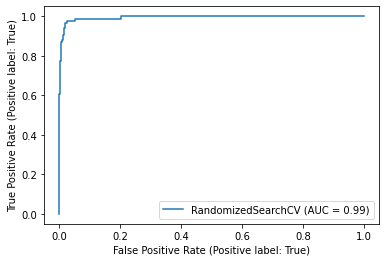

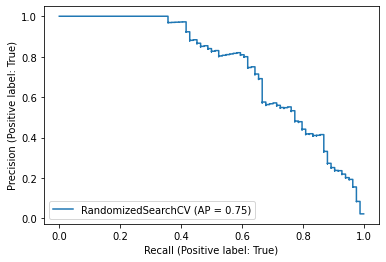

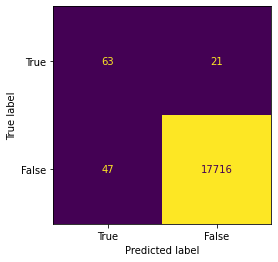

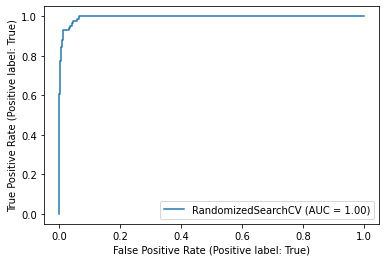

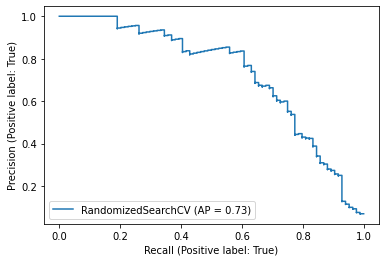

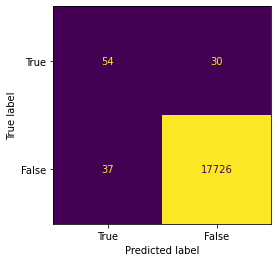

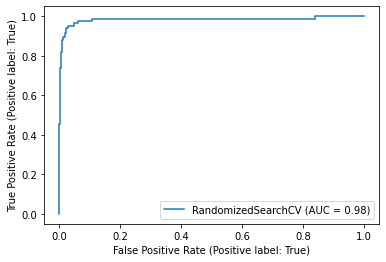

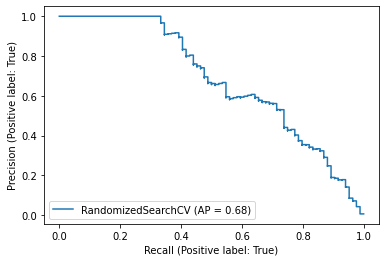

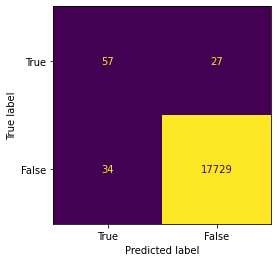

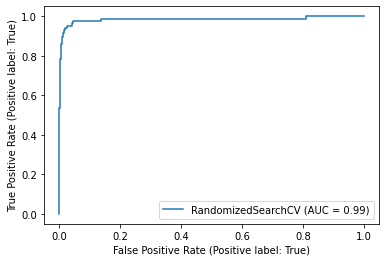

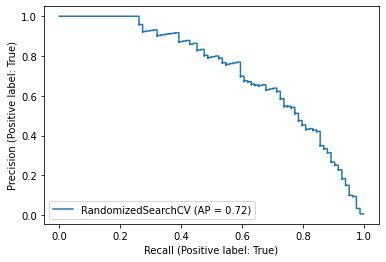

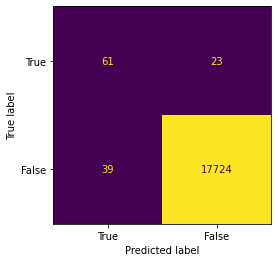

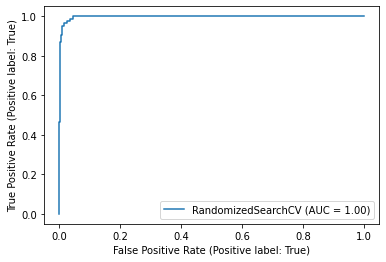

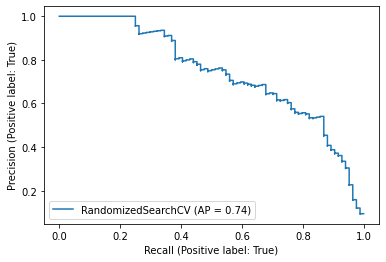

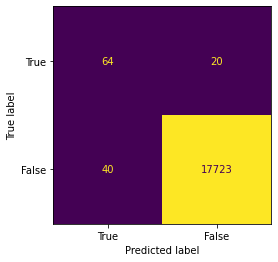

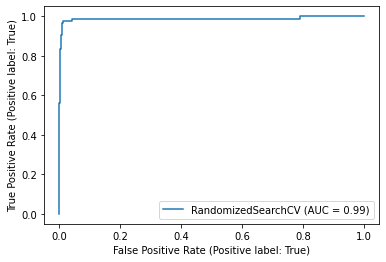

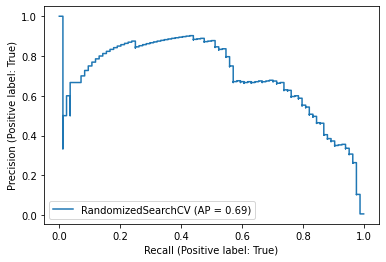

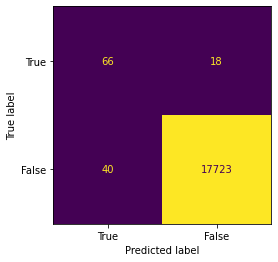

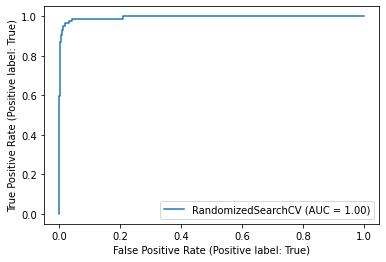

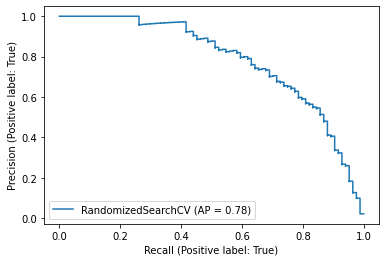

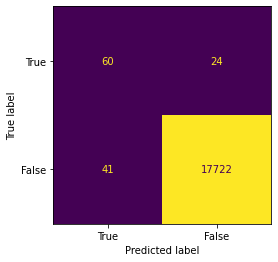

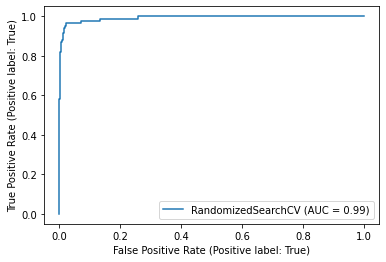

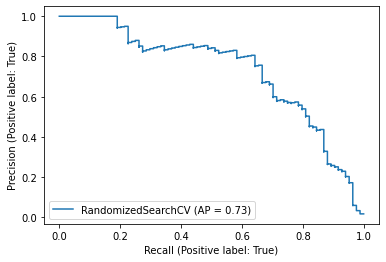

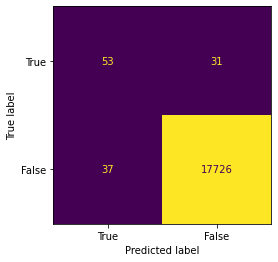

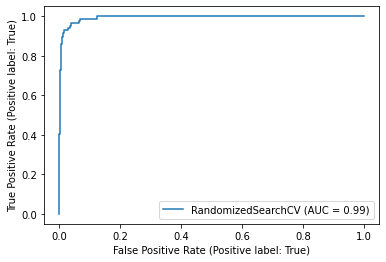

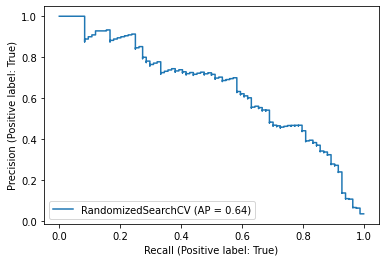

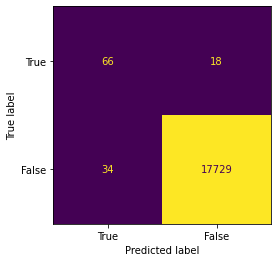

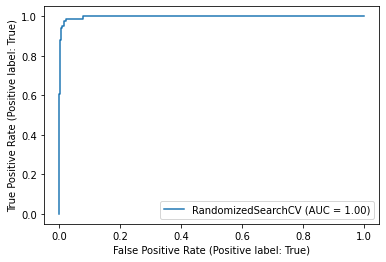

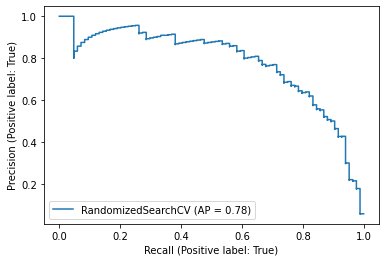

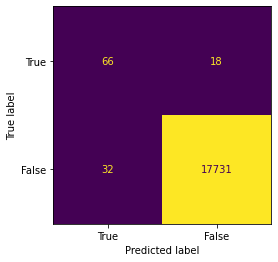

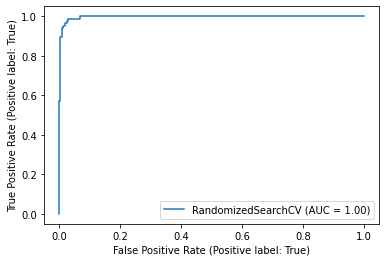

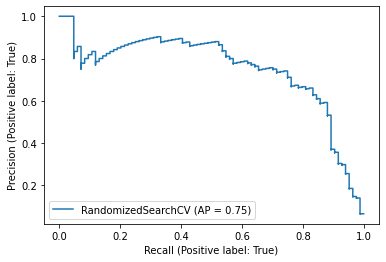

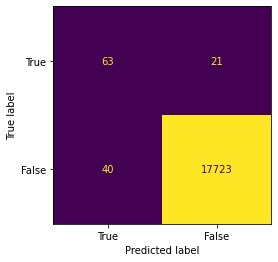

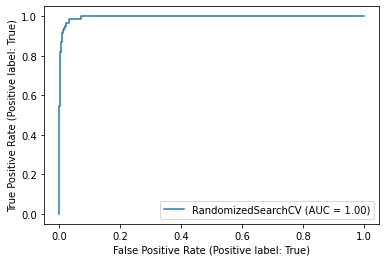

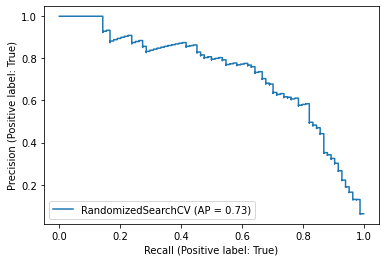

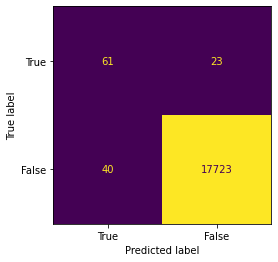

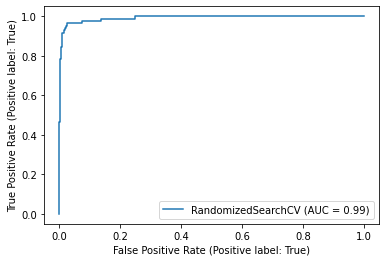

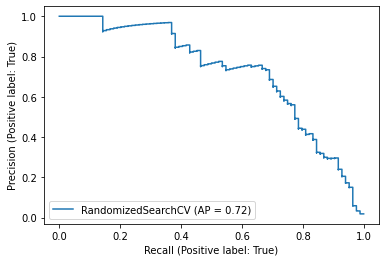

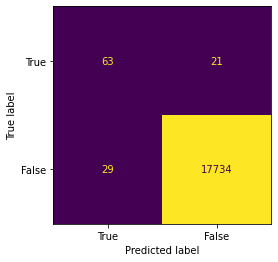

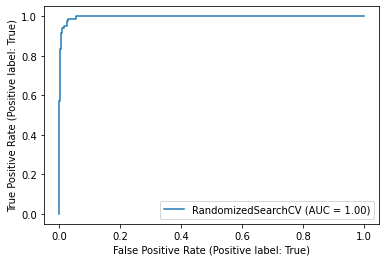

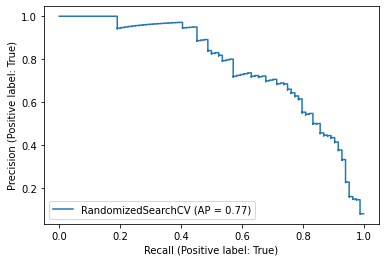

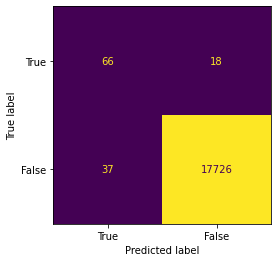

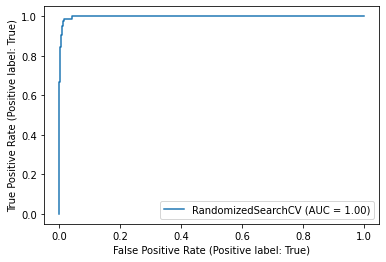

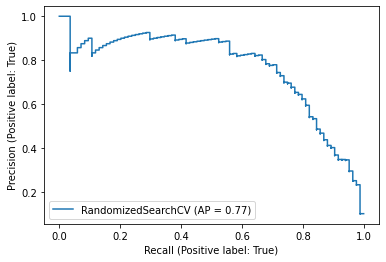

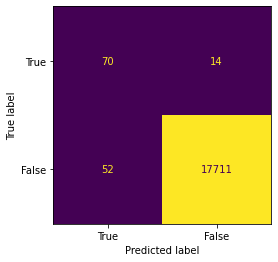

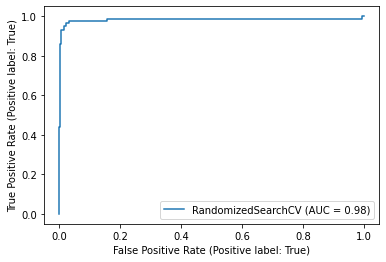

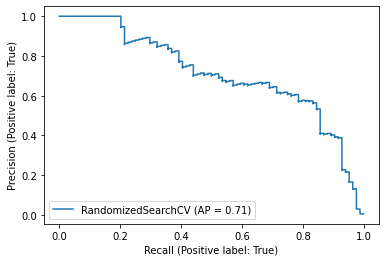

In [31]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

for i in range(25):

    ftwo_scorer = make_scorer(fbeta_score, beta=2)

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2, importance_type='gain')]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

# define search space
    # define search space
    space = dict()
    spaceEmpty = dict()
    space['classifier__num_leaves'] = [11, 16, 21, 26, 31, 36, 41, 46, 51, 56]
    space['classifier__min_data_in_leaf'] =  [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__max_depth'] = [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__learning_rate'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
    space['classifier__max_bin'] = [50, 100, 150, 200, 255, 300, 350, 400, 450, 500]

    LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

    optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedLightGBMModel.best_score_
    test_score = optimizedLightGBMModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)
    
    #feature importance
    importances = optimizedLightGBMModel.best_estimator_._final_estimator.booster_.feature_importance(importance_type='gain')
    for i,v in enumerate(importances):
        print(v)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)